In [1]:
import pandas as pd
import json
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress,norm
import numpy as np
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

pd.set_option('display.max_columns', None)

# Suppress warnings
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", message="FixedFormatter should only be used together with FixedLocator")

In [2]:
import sys
sys.path.append('../../')
from consensus_variables import *

In [3]:
plots_dir = "./plots"

## Load functions

In [4]:
# Prepare data
# ============

def get_o3d_gene_data(gene, 
                      seq_df, 
                      prob_dict,
                      score_df):
    
    # Subset gene
    seq_df_gene = seq_df[seq_df["Gene"] == gene]
    gene_len = len(seq_df_gene.Seq.values[0])
    gene_pos = pd.DataFrame({"Pos" : range(1, gene_len+1)})
    uni_id, af_f = seq_df_gene[["Uniprot_ID", "F"]].values[0]
    prob_gene = np.array(prob_dict[f"{uni_id}-F{af_f}"])
    score_gene_df = score_df[score_df["Gene"] == gene].reset_index(drop=True)
    score_gene, top_pos_score_gene = score_df[["Score", "Score_obs_sim"]].values[0]
    
    ## O3D score vector
    score_gene_df = gene_pos.merge(score_gene_df[["Pos", "Score_obs_sim", "C", "C_ext"]], how="left", on="Pos")

    # Don't include Extended clusters
    score_gene_df["C"] = (score_gene_df["C"] == 1) & (score_gene_df["C_ext"] == 0)    # Change this to include extended clusters
    score_gene_df["C"] = score_gene_df["C"].astype(int)
    score_gene_df = score_gene_df.drop(columns=["C_ext"])

    score_gene_df.columns = "Pos", "O3D_score", "Cluster"
    score_gene_df["O3D_score"] = score_gene_df["O3D_score"].fillna(0)
    score_gene_df["Cluster"] = score_gene_df["Cluster"].fillna(0)
    score_gene_df["O3D_score_norm"] = score_gene_df["O3D_score"] / sum(score_gene_df["O3D_score"])
    
    return score_gene_df, score_gene, prob_gene, top_pos_score_gene, uni_id, gene_pos


def preprocess_maf(maf_df, gene_order):
    
    # SNV
    snvs_maf = maf_df[(maf_df["TYPE"] == 'SNV') &
                        (maf_df["canonical_SYMBOL"].isin(gene_order)) &
                        (maf_df["canonical_Protein_position"] != '-' )
                       ].reset_index(drop = True)
    snvs_maf["canonical_Protein_position"] = snvs_maf["canonical_Protein_position"].astype(int)
    
    # Omega
    maf_df_trunc = snvs_maf[snvs_maf["canonical_Consequence_broader"].isin(['nonsense', 'essential_splice'])]
    maf_df_synon = snvs_maf[snvs_maf["canonical_Consequence_broader"] == 'synonymous']
    maf_df_miss = snvs_maf[snvs_maf["canonical_Consequence_broader"] == 'missense']
    
    return maf_df, snvs_maf, maf_df_trunc, maf_df_synon, maf_df_miss


def get_maf_pos_count(gene, maf_df, gene_pos):
    
    # Subset gene and cols
    cols = ["SYMBOL",
            "TYPE",
            "Feature", 
            "canonical_Feature", 
            "canonical_Consequence",
            "canonical_Consequence_broader", 
            "canonical_Protein_position"]
    
    df_gene = maf_df.loc[maf_df["SYMBOL"] == gene, cols]
    
    # Get per-position mutations count
    df_gene_count = df_gene.groupby("canonical_Protein_position").apply(lambda x: len(x)).reset_index().astype(int)
    df_gene_count.columns = "Pos", "Count"
    df_gene_count = gene_pos.merge(df_gene_count, how="left", on="Pos")
    
    return df_gene_count


def get_ofml_score_gene(gene, fig3_data_path):
    
    mutations_in_gene = pd.read_table(f"{fig3_data_path}/mutations_scored.{gene}.tsv")
    ofml_muts_score_gene = mutations_in_gene.groupby(by = "canonical_Protein_position").agg( { "MUT_ID" : 'count',
                                                                                               "CADDscore" : 'mean'}).reset_index()
    ofml_muts_score_gene.columns = "Pos", "Count", "CADD_score"
    
    return ofml_muts_score_gene 


def get_frameshift_indels_maf(maf_df_f):
    
    # Filter and somatic only
    indel_maf_df = maf_df_f.loc[
                        (maf_df_f["TYPE"].isin(["INSERTION", "DELETION"]))
                        ].reset_index(drop = True)
    # indel_maf_df["INDEL_LENGTH"] = (indel_maf_df["REF"].str.len() - indel_maf_df["ALT"].str.len()).abs()
    # indel_maf_df["INDEL_INFRAME"] = [ x % 3 == 0 for x in indel_maf_df["INDEL_LENGTH"] ]
    # indel_maf_df.loc[indel_maf_df["INDEL_LENGTH"] >= 15 , "INDEL_INFRAME"] = False
    # indel_maf_df.loc[indel_maf_df["canonical_Consequence_broader"] == 'nonsense' , "INDEL_INFRAME"] = False
    # indel_maf_df.loc[indel_maf_df["canonical_Consequence_broader"] == 'essential_splice' , "INDEL_INFRAME"] = False
    
    # Observed frameshift indels + inframes of length >= 5 AA
    frameshift_indels = indel_maf_df[(~indel_maf_df["INDEL_INFRAME"]) &
                                 (indel_maf_df["canonical_Protein_position"] != '-' )].reset_index(drop = True)

    # Inframe indels
    inframe_indels = indel_maf_df[(indel_maf_df["INDEL_INFRAME"]) &
                                  (indel_maf_df["canonical_Protein_position"] != '-' )].reset_index(drop = True)
    
    return frameshift_indels, inframe_indels


def get_frameshift_indels_gene(gene, frameshift_indels_df, inframe_indels_df, gene_pos):
    
    ## Frameshift indels
    frameshift_indels_gene = frameshift_indels_df[frameshift_indels_df["canonical_SYMBOL"] == gene]

    # Count by pos considering first pos as protein pos
    frameshift_indels_gene.canonical_Protein_position = frameshift_indels_gene.canonical_Protein_position.apply(lambda x: x.split("-")[0])
    frameshift_indels_gene.canonical_Protein_position = frameshift_indels_gene.canonical_Protein_position[
        frameshift_indels_gene.canonical_Protein_position.apply(lambda x: x.isdigit())]
    frameshift_indels_count_gene = frameshift_indels_gene.groupby("canonical_Protein_position").apply(lambda x: len(x)).reset_index().astype(int)
    frameshift_indels_count_gene.columns = "Pos", "Count"
    frameshift_indels_count_gene = gene_pos.merge(frameshift_indels_count_gene, how="left", on="Pos")
    
    ## Inframe indels
    inframe_indels_gene = inframe_indels_df[inframe_indels_df["canonical_SYMBOL"] == gene]

    # Count
    inframe_indels_gene.canonical_Protein_position = inframe_indels_gene.canonical_Protein_position.apply(lambda x: x.split("-")[0])
    inframe_indels_gene.canonical_Protein_position = inframe_indels_gene.canonical_Protein_position[
        inframe_indels_gene.canonical_Protein_position.apply(lambda x: x.isdigit())]
    inframe_indels_count_gene = inframe_indels_gene.groupby("canonical_Protein_position").apply(lambda x: len(x)).reset_index().astype(int)
    inframe_indels_count_gene.columns = "Pos", "Count"
    inframe_indels_count_gene = gene_pos.merge(inframe_indels_count_gene, how="left", on="Pos")
    
    return frameshift_indels_count_gene, inframe_indels_count_gene

In [5]:
# Plot
# ====

def init_plot_pars():
    
    plot_pars = {"fsize"                   : (15,10),
                 "hspace"                  : 0.1,                     # General space between all tracks
                 "ofml_cbar_coord"         : (0.04, 0.36, 1.1, 0.85), # Box to anchor coordinate for OncodriveFML color bar | ALT: (0.01, 0.35, 0.9, 1)
                 "track_title_x_coord"     : 0.83,                    # x-coordinate (respect to protein len) for track txt title
                 "score_txt_x_coord"       : 1.13,                    # as track title but for track score txt
                 "track_title_fontsize"    : 14,
                 "ylabel_fontsize"         : 13.5,
                 "xlabel_fontsize"         : 13.5,
                 "ylabel_pad"              : -50,
                 "ticksize"                : 10.5,
                 "legend_fontsize"         : 11,
                 "legend_frameon"          : True,
                 "dpi"                     : 300,
                 "domain_y_bbox_to_anchor" : 9,
                 "y_labels_coord"          : [-0.05, 0.5],
                }
    plot_pars["colors"] = {"ofml"        : "viridis_r",
                           "omega_trunc" : "#FA5E32",
                           "omega_synon" : "#89E4A2",
                           "omega_miss"  : "#FABE4A",
                           "o3d_score"   : "#6DBDCC",
                           "o3d_cluster" : "#DAF0F8",
                           "o3d_prob"    : "darkgray",
                           "frameshift"  : "#E4ACF4",
                           "inframe"     : "C5",
                           "hv_lines"    : "lightgray"      # General horizontal and vertical lines (e.g., needle plot vline)
                           }
    plot_pars["h_ratios"] = {"omega_trunc" : 0.3,
                             "omega_synon" : 0.3,
                             "omega_miss"  : 0.3,
                             "space1"      : 0.015,
                             "o3d"         : 0.5,
                             "space2"      : 0.015,
                             "ofml"        : 0.5,
                             "space3"      : 0.015,
                             "indels"      : 0.5,
                             "space4"      : 0.015,
                             "domain"      : 0.07
                            }
    plot_pars["domain_x_bbox_to_anchor"]   = {"ARID1A" : 1.182,
                                            "KDM6A"  : 1.14,
                                            "KMT2D"  : 1.184,
                                            "EP300"  : 1.2,
                                            "CREBBP" : 1.2,
                                            "NOTCH2" : 1.14,
                                            "KMT2C"  : 1.18
                                            }
    
    return plot_pars


def plot_count_track(pos_track, 
                     axes, 
                     ax=0, 
                     neg_track=None, 
                     gene_len=None,
                     col_pos_track="gray",
                     col_neg_track="gray",
                     label_pos_track=None,
                     label_neg_track=None,
                     ymargin=None,
                     hv_lines="lightgray"):
    
    axes[ax].vlines(pos_track["Pos"], ymin=0, ymax=pos_track["Count"], color=hv_lines, lw=1, zorder=1, alpha=0.5)
    axes[ax].scatter(pos_track["Pos"], pos_track["Count"], color='white', zorder=3, lw=1, ec="white") # To cover the overlapping needle top part
    axes[ax].scatter(pos_track["Pos"].values, pos_track["Count"].values, color=col_pos_track, zorder=4, 
                     alpha=0.7, lw=0.1, ec="black", s=60, label=label_pos_track)
    
    if isinstance(neg_track, pd.DataFrame):
        if isinstance(gene_len, int):
            axes[ax].hlines(0, xmin=0, xmax=gene_len, color="gray", lw=0.6, zorder=1)
        axes[ax].vlines(neg_track["Pos"], ymin=-neg_track["Count"], ymax=0, color=hv_lines, lw=1, zorder=1, alpha=0.5)
        axes[ax].scatter(neg_track["Pos"], -neg_track["Count"], color='white', zorder=3, lw=1, ec="white") # To cover the overlapping needle top part
        axes[ax].scatter(pos_track["Pos"].values, -neg_track["Count"].values, color=col_neg_track, zorder=4, 
                         alpha=0.7, lw=0.1, ec="black", s=60, label=label_neg_track)
        axes[ax].set_yticklabels(abs(axes[ax].get_yticks()))
        
    if ymargin is not None:
        axes[ax].set_ylim(-np.max(neg_track["Count"])-ymargin, np.max(pos_track["Count"])+ymargin)
        
        
def add_ax_text(score, pvalue, y_text, x_text, ax, y_shift=0.2, y_adjust=0, equal_less=True):

    ax.text(x_text, y_text+(y_text*y_shift)+y_adjust, 
            fr'$\mathit{{Score}}$ = {np.round(score, 2)}', ha='center', va='center', fontsize=13.5, color="black")
    
    equal = "≤" if equal_less else "="
    ax.text(x_text, y_text-(y_text*y_shift)+y_adjust, 
            fr'$\mathit{{p}}$-value {equal} {pvalue}', ha='center', va='center', fontsize=13.5, color="black")

    
def get_transcript_ids(gene, maf_df_f, o3d_seq_df):
    
    canonical_tr = maf_df_f[maf_df_f["SYMBOL"] == gene].canonical_Feature.unique()[0]
    o3d_tr = o3d_seq_df[o3d_seq_df["Gene"] == gene].Ens_Transcr_ID.values[0]
    
    return canonical_tr, o3d_tr


def plot_gene_selection_signals(maf_trunc_count_gene,
                                maf_miss_count_gene,
                                maf_synon_count_gene,
                                frameshift_indels_count_gene,
                                inframe_indels_count_gene,
                                ofml_muts_score_gene,
                                o3d_score_gene,
                                o3d_prob_gene,
                                plot_pars,
                                domain_df=None,
                                add_track_title_text=True,
                                add_score_text=False,
                                rm_spines=False,
                                light_spines=False,
                                output_path=None,
                                gene=None,
                                clustering_full_filling=True,
                                len_txt_thr=2400):
    
    gene_len = len(o3d_prob_gene)
    fig, axes = plt.subplots(len(plot_pars["h_ratios"]), 1, 
                             figsize=plot_pars["fsize"], 
                             sharex=True, 
                             gridspec_kw={'hspace': plot_pars["hspace"], 
                                          'height_ratios': plot_pars["h_ratios"].values()})
    colors = plot_pars["colors"]


    # Omega
    # =====

    # Omega trunc (nonsense)
    ax=0
    plot_count_track(maf_trunc_count_gene, axes, ax=ax,  gene_len=gene_len, col_pos_track=colors["omega_trunc"])
    if add_score_text:
        add_ax_text(score=np.round(omega_truncating_score, 2), 
                    pvalue=omega_truncating_pvalue,
                    y_text=np.max(maf_synon_count_gene["Count"])/2, 
                    x_text=gene_len*plot_pars["score_txt_x_coord"], 
                    ax=axes[ax],
                    y_shift=0.9, 
                    y_adjust=2.4)
    if add_track_title_text:
        axes[ax].text(gene_len*plot_pars["track_title_x_coord"], 4.7, 
                      fr'$\mathbf{{Omega}}$ $\mathbf{{Nonsense}}$',  
                      ha='center', va='center', fontsize=plot_pars["track_title_fontsize"], color="black")
    axes[ax].set_ylabel('Truncating\ncount', fontsize=plot_pars["ylabel_fontsize"], rotation=0, labelpad=plot_pars["ylabel_pad"], va='center', ha = 'right')
    axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
    
    n_max = np.max(maf_trunc_count_gene["Count"])
    j = 12
    i = 14
    axes[ax].set_ylim(-n_max/i, n_max + n_max/j)
    
    axes[ax].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
    axes[ax].tick_params(axis='y', labelsize=plot_pars["ticksize"])
    if rm_spines:
        axes[ax].spines['top'].set_visible(False)
        axes[ax].spines['right'].set_visible(False)
    elif light_spines:
        axes[ax].spines['top'].set_color(colors["hv_lines"])
        axes[ax].spines['right'].set_color(colors["hv_lines"])

    # Omega synonym
    ax=1
    plot_count_track(maf_synon_count_gene, axes, ax=ax, gene_len=gene_len, col_pos_track=colors["omega_synon"], hv_lines=colors["hv_lines"])
    axes[ax].set_ylabel('Synonymous\ncount', fontsize=plot_pars["ylabel_fontsize"], rotation=0, labelpad=plot_pars["ylabel_pad"], va='center', ha = 'right')
    axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
    
    n_max = np.max(maf_synon_count_gene["Count"])
    j = 10
    i = 24
    axes[ax].set_ylim(-n_max/i, n_max + n_max/j)
    
    axes[ax].tick_params(axis='y', labelsize=plot_pars["ticksize"])
    axes[ax].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
    axes[ax].spines['top'].set_visible(False)
    if rm_spines:
        axes[ax].spines['right'].set_visible(False)
    elif light_spines:
        axes[ax].spines['right'].set_color(colors["hv_lines"])

    # Omega miss
    ax=2
    plot_count_track(maf_miss_count_gene, axes, ax=ax, gene_len=gene_len, col_pos_track=colors["omega_miss"], hv_lines=colors["hv_lines"])
    y_text=np.max(maf_miss_count_gene["Count"])/2 
    if add_score_text:
        add_ax_text(score=np.round(omega_misss_score, 2), 
                    pvalue=omega_misss_pvalue,
                    y_text=y_text, 
                    x_text=gene_len*plot_pars["score_txt_x_coord"], 
                    y_shift=0.3,
                    ax=axes[ax], 
                    y_adjust=4)
    if add_track_title_text:
        axes[ax].text(gene_len*plot_pars["track_title_x_coord"], y_text+y_text*0.6935, 
                      fr'$\mathbf{{Omega}}$ $\mathbf{{Missense}}$', 
                      ha='center', va='center', fontsize=plot_pars["track_title_fontsize"], color="black")
    axes[ax].set_ylabel('Missense\ncount', fontsize=plot_pars["ylabel_fontsize"], rotation=0, labelpad=plot_pars["ylabel_pad"], va='center', ha = 'right')
    axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
    
    n_max = np.max(maf_miss_count_gene["Count"])
    j = 10
    i = 10
    axes[ax].set_ylim(-n_max/i, n_max + n_max/j)
  
    axes[ax].spines['top'].set_visible(False)
    axes[ax].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
    axes[ax].tick_params(axis='y', labelsize=plot_pars["ticksize"])
    if rm_spines:
        axes[ax].spines['right'].set_visible(False)
    elif light_spines:
        axes[ax].spines['right'].set_color(colors["hv_lines"])
        
        
    # Oncodrive3D
    # ===========

    ax=4
    ymax = np.max(o3d_score_gene["O3D_score_norm"])
    ymax = ymax + ymax / 30
    axes[ax].plot(range(1, gene_len+1), o3d_score_gene["O3D_score_norm"], zorder=2, color=colors["o3d_score"], lw=1, label="Clustering score")                       
    axes[ax].plot(range(1, gene_len+1), -o3d_prob_gene, zorder=3, color=colors["o3d_prob"], lw=1, label="Missense mut probability")  
    if clustering_full_filling:
        axes[ax].fill_between(o3d_score_gene['Pos'], 0, ymax, where=(o3d_score_gene['Cluster'] == 1), 
                              color=colors["o3d_cluster"], label='Cluster', alpha=1, zorder=0, lw=1.5)
    else:
        axes[ax].fill_between(o3d_score_gene['Pos'], 0, o3d_score_gene["O3D_score_norm"], 
                              where=(o3d_score_gene['Cluster'] == 1), color=colors["o3d_cluster"], 
                              label='Cluster', alpha=1, zorder=0, lw=1.5)
    axes[ax].axhline(y=ymax, color='white', lw=2, zorder=1)
    if add_score_text:
        add_ax_text(score=np.round(o3d_score, 2), 
                    pvalue=o3d_pvalue,
                    y_text=(np.max(o3d_score_gene["O3D_score_norm"]) + np.max(o3d_prob_gene))/2, 
                    x_text=gene_len*plot_pars["score_txt_x_coord"], 
                    ax=axes[ax], 
                    y_shift=0.15,
                    y_adjust=-0.0075,
                    equal_less=True)
    if add_track_title_text:
        axes[ax].text(gene_len*plot_pars["track_title_x_coord"], 0.015, 
                      fr'$\mathbf{{3D}}$-$\mathbf{{Clustering}}$', 
                      ha='center', va='center', fontsize=plot_pars["track_title_fontsize"], color="black")
        
    axes[ax].set_ylabel('3D clustering', fontsize=plot_pars["ylabel_fontsize"], rotation=0, labelpad=plot_pars["ylabel_pad"], va='center', ha = 'right')
    axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
    axes[ax].yaxis.set_major_locator(MaxNLocator(integer=False, nbins=4))
    tick_labels = [np.round(abs(tick), 3) for tick in axes[ax].get_yticks()]
    axes[ax].set_yticklabels(tick_labels)
    axes[ax].tick_params(axis='y', labelsize=plot_pars["ticksize"])
    
    axes[ax].legend(loc="upper left", fontsize=plot_pars["legend_fontsize"], frameon=plot_pars["legend_frameon"])
    #axes[ax].legend(bbox_to_anchor=[0, 0.35, 1, 0])
    if rm_spines:
        axes[ax].spines['top'].set_visible(False)
        axes[ax].spines['right'].set_visible(False)
    elif light_spines:
        axes[ax].spines['top'].set_color(colors["hv_lines"])
        axes[ax].spines['right'].set_color(colors["hv_lines"])

        
    # OncodriveFML
    # ============

    ax=6
    axes[ax].vlines(ofml_muts_score_gene["Pos"].values, ymin=0, ymax=ofml_muts_score_gene["Count"], color=colors["hv_lines"], lw=1, zorder=1, alpha=0.5)
    fml_scatter = axes[ax].scatter(ofml_muts_score_gene["Pos"].values, ofml_muts_score_gene["Count"].values, 
                                   c=ofml_muts_score_gene["CADD_score"].values, cmap=colors["ofml"], zorder=4, 
                                   alpha=0.7, lw=0.1, ec="black", s=60, label="SNV")
    
    y_text=np.round(np.max(ofml_muts_score_gene["Count"])/2)
    if add_score_text:
        add_ax_text(score=np.round(ofml_score, 2), 
                    pvalue=ofml_pvalue,
                    y_text=y_text, 
                    x_text=gene_len*plot_pars["score_txt_x_coord"], 
                    ax=axes[ax], 
                    y_adjust=3,
                    equal_less=True)

    if add_track_title_text:
        axes[ax].text(gene_len*plot_pars["track_title_x_coord"], y_text+y_text*0.8, 
                      fr'$\mathbf{{Functional}}$ $\mathbf{{Impact}}$', 
                      ha='center', va='center', fontsize=plot_pars["track_title_fontsize"], color="black")

    inset_ax = inset_axes(axes[ax], width="10%", height="10%", loc='center left', 
                          bbox_to_anchor=plot_pars["ofml_cbar_coord"], bbox_transform=axes[ax].transAxes, borderpad=0)
    cbar = plt.colorbar(fml_scatter, cax=inset_ax, orientation='horizontal')
    cbar.set_label('Impact score', fontsize=plot_pars["legend_fontsize"])
    cbar.ax.tick_params(labelsize=plot_pars["ticksize"])

    n_max = np.max(ofml_muts_score_gene["Count"])
    j = 14.5
    i = 19.33
    axes[ax].set_ylim(-n_max/i, n_max + n_max/j)    
  
    axes[ax].set_ylabel('SNV count', fontsize=plot_pars["ylabel_fontsize"], rotation=0, labelpad=plot_pars["ylabel_pad"], va='center', ha = 'right')
    axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
    axes[ax].tick_params(axis='y', labelsize=plot_pars["ticksize"])
    
    if rm_spines:
        axes[ax].spines['top'].set_visible(False)
        axes[ax].spines['right'].set_visible(False)
    elif light_spines:
        axes[ax].spines['top'].set_color(colors["hv_lines"])
        axes[ax].spines['right'].set_color(colors["hv_lines"])        
        

    # Frameshift enrichment
    # =====================

    ax=8
    plot_count_track(frameshift_indels_count_gene, axes, ax=ax, neg_track=inframe_indels_count_gene, gene_len=gene_len,
                     col_pos_track=colors["frameshift"], col_neg_track=colors["inframe"], label_pos_track="Frameshift", label_neg_track="Inframe",
                     ymargin=1, hv_lines=colors["hv_lines"])

    n_max = np.max((np.max(frameshift_indels_count_gene["Count"]), np.max(inframe_indels_count_gene["Count"])))
    j = 10
    n_max_lim = n_max + n_max/j
    axes[ax].set_ylim(-n_max_lim, n_max_lim) 
    
    if add_score_text:
        add_ax_text(score=np.round(indels_score, 2), 
                    pvalue=np.round(indels_pvalue, 2),
                    y_text=(np.max(frameshift_indels_count_gene["Count"]) + np.max(inframe_indels_count_gene["Count"]))/2, 
                    x_text=gene_len*plot_pars["score_txt_x_coord"], 
                    ax=axes[ax], 
                    y_shift=0.24,
                    y_adjust=0.4,
                    equal_less=False)
    if add_track_title_text:
        axes[ax].text(gene_len*plot_pars["track_title_x_coord"], 3.9, 
                      fr'$\mathbf{{Frameshift}}$ $\mathbf{{enrichment}}$', 
                      ha='center', va='center', fontsize=plot_pars["track_title_fontsize"], color="black")
    axes[ax].legend(loc="lower left", fontsize=plot_pars["legend_fontsize"], frameon=plot_pars["legend_frameon"])
    axes[ax].set_ylabel('Indels count', fontsize=plot_pars["ylabel_fontsize"], rotation=0, labelpad=plot_pars["ylabel_pad"], va='center', ha = 'right')
    axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
    
    axes[ax].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
    tick_labels = [abs(int(tick)) for tick in axes[ax].get_yticks()]
    axes[ax].set_yticklabels(tick_labels)
    
    if rm_spines:
        axes[ax].spines['top'].set_visible(False)
        axes[ax].spines['right'].set_visible(False)
    elif light_spines:
        axes[ax].spines['top'].set_color(colors["hv_lines"])
        axes[ax].spines['right'].set_color(colors["hv_lines"])


    # Domain
    # ======
    
    ax=10
    if isinstance(domain_df, pd.DataFrame):
        domain_color_dict = {}

        for n, name in enumerate(domain_df["Description"].unique()):
            domain_color_dict[name] = f"C{n}"

        n = 0
        added_domain = []
        for i, row in domain_df.iterrows():
            if pd.Series([row["Description"], row["Begin"], row["End"]]).isnull().any():
                continue

            name = row["Description"]
            start = int(row["Begin"])
            end = int(row["End"])
            if name not in added_domain and (gene_len >= len_txt_thr):
                axes[ax].fill_between(range(start, end + 1), -0.5, 0.45, alpha=0.5, color=domain_color_dict[name], label=name, lw=0.5)
            else:
                axes[ax].fill_between(range(start, end + 1), -0.5, 0.45, alpha=0.5, color=domain_color_dict[name], lw=0.5)
            
            if name not in added_domain:
                if gene_len < len_txt_thr:
                    y = -0.04
                    axes[ax].text(((start + end) / 2)+0.5, y, name, ha='center', va='center', fontsize=10, color="black")
                added_domain.append(name)

        if (gene_len >= len_txt_thr) and len(added_domain) > 0:
            axes[ax].legend(fontsize=plot_pars["legend_fontsize"], frameon=False, 
                            bbox_to_anchor=(plot_pars["domain_x_bbox_to_anchor"][gene], plot_pars["domain_y_bbox_to_anchor"]), title = "Domain",
                            title_fontsize=plot_pars["legend_fontsize"],
                            handleheight=0.67, handlelength=2) 
        axes[ax].set_yticks([])
    else:
        axes[ax].remove()

        
    # Spaces
    # =====
    axes[3].remove()
    axes[5].remove()
    axes[7].remove()
    axes[9].remove()

    
    # X axes
    # ======
    axes[ax].tick_params(axis='y', labelsize=plot_pars["ticksize"])
    axes[ax].tick_params(axis='x', labelsize=plot_pars["ticksize"])
    axes[ax].set_xlabel('Protein position', fontsize=plot_pars["xlabel_fontsize"]) 

    if gene is not None:
        if not clustering_full_filling:
            fig.suptitle(f"{gene}", y=0.93, fontsize = 15)
        else:
            fig.suptitle(gene, y=0.93)
    
    if output_path is not None:
        print(f"Saving {output_path}")
        plt.savefig(output_path, dpi=plot_pars["dpi"], bbox_inches='tight')
    plt.show()
    

def generate_plot(gene, 
                  o3d_seq_df,
                  o3d_annot_df,
                  o3d_prob,
                  o3d_score,
                  maf_df_f, 
                  snv_df, 
                  trunc_df, 
                  synon_df, 
                  miss_df,
                  plot_pars,
                  domain_df=None,
                  add_track_title_text=False,
                  add_score_text=False,
                  rm_spines=True,
                  light_spines=False,
                  output_path=None,
                  clustering_full_filling=True):
    
    # Prepare data
    # ============

    # O3D gene
    o3d_score_df_gene, o3d_score_gene, o3d_prob_gene, o3d_top_pos_score_gene, uni_id, gene_pos = get_o3d_gene_data(gene, 
                                                                                                                   o3d_seq_df, 
                                                                                                                   o3d_prob,
                                                                                                                   o3d_score)

    # MAF gene
    snv_count_gene = get_maf_pos_count(gene, snv_df, gene_pos)
    trunc_count_gene = get_maf_pos_count(gene, trunc_df, gene_pos)
    synon_count_gene = get_maf_pos_count(gene, synon_df, gene_pos)
    miss_count_gene = get_maf_pos_count(gene, miss_df, gene_pos)

    # OFML gene
    ofml_score_gene = get_ofml_score_gene(gene, ofml_data)

    # Indels
    frameshift_indels_df, inframe_indels_df = get_frameshift_indels_maf(maf_df_f)
    frameshift_indels_count_gene, inframe_indels_count_gene = get_frameshift_indels_gene(gene, 
                                                                                         frameshift_indels_df, 
                                                                                         inframe_indels_df,
                                                                                         gene_pos)

    # Domain
    domain_gene = o3d_annot_df[(o3d_annot_df["Gene"] == gene) & 
                               (o3d_annot_df["Type"] == "DOMAIN") & 
                               (o3d_annot_df["Evidence"] == "Pfam")].reset_index(drop=True)
    
    # Transcripts and Uniprot ID
    canonical_tr, o3d_tr = get_transcript_ids(gene, maf_df_f, o3d_seq_df)
    print(f"> {gene} - {canonical_tr} - {o3d_tr} - {uni_id}")
    
    # Plot
    # ====
    
    if output_path is not None:
        if clustering_full_filling:
            output_path = f"{output_path}/{gene}.png"
        else:
            output_path = f"{output_path}/{gene}_alt_clust_filling.png"
    plot_gene_selection_signals(trunc_count_gene,
                                miss_count_gene,
                                synon_count_gene,
                                frameshift_indels_count_gene,
                                inframe_indels_count_gene,
                                ofml_score_gene,
                                o3d_score_df_gene,
                                o3d_prob_gene,
                                plot_pars,
                                domain_gene,
                                add_track_title_text,
                                add_score_text,
                                rm_spines,
                                light_spines,
                                output_path,
                                gene,
                                clustering_full_filling)

## Load

In [6]:
# Init
run_name = "all_samples"

maf_file = somatic_maf_file
o3d_datasets = "/data/bbg/nobackup/scratch/oncodrive3d/datasets_mane_240506"
o3d_annotations = "/data/bbg/nobackup/scratch/oncodrive3d/annotations_mane_240506"
ofml_data = "./data/"

o3d_genes = ["KMT2D","EP300","ARID1A","CREBBP","NOTCH2","KMT2C","RB1",
              "RBM10","TP53","FGFR3","CDKN1A","FOXQ1",
              #"PIK3CA","TERT", "KDM6A", "STAG2"
             ]

In [7]:
# Oncodrive3D

o3d_seq_df = pd.read_table(f"{o3d_datasets}/seq_for_mut_prob.tsv")
o3d_annot_df = pd.read_csv(f"{o3d_annotations}/uniprot_feat.tsv", sep="\t")

o3d_prob = f"{deepcsa_run_dir}/oncodrive3d/run/{run_name}/{run_name}.miss_prob.processed.json"
o3d_prob = json.load(open(o3d_prob, encoding="utf-8"))

o3d_score = f"{deepcsa_run_dir}/oncodrive3d/run/{run_name}/{run_name}.3d_clustering_pos.csv"
o3d_score = pd.read_csv(o3d_score)[["Gene", "Pos", "Score", "Score_obs_sim", "pval", "C", "C_ext"]]


# MAF

maf_df = pd.read_csv(maf_file, sep = "\t")
maf_df_f, snv_df, trunc_df, synon_df, miss_df = preprocess_maf(maf_df, o3d_genes)

/tmp/ipykernel_2168818/2561039417.py:15: DtypeWarning: Columns (49,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  maf_df = pd.read_csv(maf_file, sep = "\t")


In [8]:
# maf_df[['INDEL_LENGTH', 'INDEL_INFRAME', 'INDEL_MULTIPLE3']].value_counts()

## Patch to map non-MANE Uniprot ID to MANE ones
__Issue__: Oncodrive3D did run using canonical transcripts, for most of the genes, the protein are identical but it might change the Uniprot ID and it definitely change the annotations (e.g., domains coordinates)  
__Solution temp__: apply this patch to MAP non-MANE to MANE Uniprot IDs to be able to load the probability computed by Oncodrive3D (probability are saved with Uniprot ID they were used in the run)  
__Solution perm__: re-run Oncodrive3D using MANE datasets and annotations and re-run this notebook without this patch  

In [9]:
o3d_datasets_canonical = "/data/bbg/nobackup/scratch/oncodrive3d/datasets_240506"
o3d_seq_df_canonical = pd.read_table(f"{o3d_datasets_canonical}/seq_for_mut_prob.tsv")

for gene in o3d_genes:
    uni_id, af_f, transcript = o3d_seq_df_canonical.loc[o3d_seq_df_canonical["Gene"] == gene, ["Uniprot_ID", "F", "Ens_Transcr_ID"]].values[0]
    uni_id_mane, af_f_mane, transcript_mane = o3d_seq_df.loc[o3d_seq_df["Gene"] == gene, ["Uniprot_ID", "F", "Ens_Transcr_ID"]].values[0]
    
    key = f"{uni_id}-F{af_f}"
    key_mane = f"{uni_id_mane}-F{af_f_mane}"
    
    if not key_mane in o3d_prob:
        print(key_mane, transcript, transcript_mane)
        o3d_prob[key_mane] = o3d_prob[key]

A0A024RDV3-F1 ENST00000267163 ENST00000267163
A0A0S2Z4W4-F1 ENST00000377604 ENST00000377604
K7PPA8-F1 ENST00000269305 ENST00000269305
A0A024RCX5-F1 ENST00000244741 ENST00000244741


In [10]:
o3d_prob.keys()

dict_keys(['O14497-F1', 'Q9NSY1-F1', 'P38936-F1', 'Q92793-F1', 'Q09472-F1', 'P22607-F1', 'P22455-F1', 'Q9C009-F1', 'Q8WXH2-F1', 'O15550-F1', 'Q8NEZ4-F19M', 'O14686-F22M', 'Q8IZL2-F1', 'Q10571-F1', 'Q9Y6Q9-F1', 'Q04721-F1', 'P42336-F1', 'P06400-F1', 'P98175-F1', 'Q9Y2K2-F1', 'Q8N3U4-F1', 'O14746-F1', 'P04637-F1', 'A0A024RDV3-F1', 'A0A0S2Z4W4-F1', 'K7PPA8-F1', 'A0A024RCX5-F1'])

## Subset gene and plot

> TP53 - ENST00000269305 - ENST00000269305 - K7PPA8


/tmp/ipykernel_2168818/2062399944.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gene_count = df_gene.groupby("canonical_Protein_position").apply(lambda x: len(x)).reset_index().astype(int)
/tmp/ipykernel_2168818/2062399944.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gene_count = df_gene.groupby("canonical_Protein_position").apply(lambda x: len(x)).reset_index().astype(int)
/tmp/ipykern

Saving ./plots/TP53.png


/tmp/ipykernel_2168818/3958490548.py:254: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[ax].set_yticklabels(tick_labels)
/tmp/ipykernel_2168818/3958490548.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[ax].set_yticklabels(abs(axes[ax].get_yticks()))
/tmp/ipykernel_2168818/3958490548.py:346: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[ax].set_yticklabels(tick_labels)


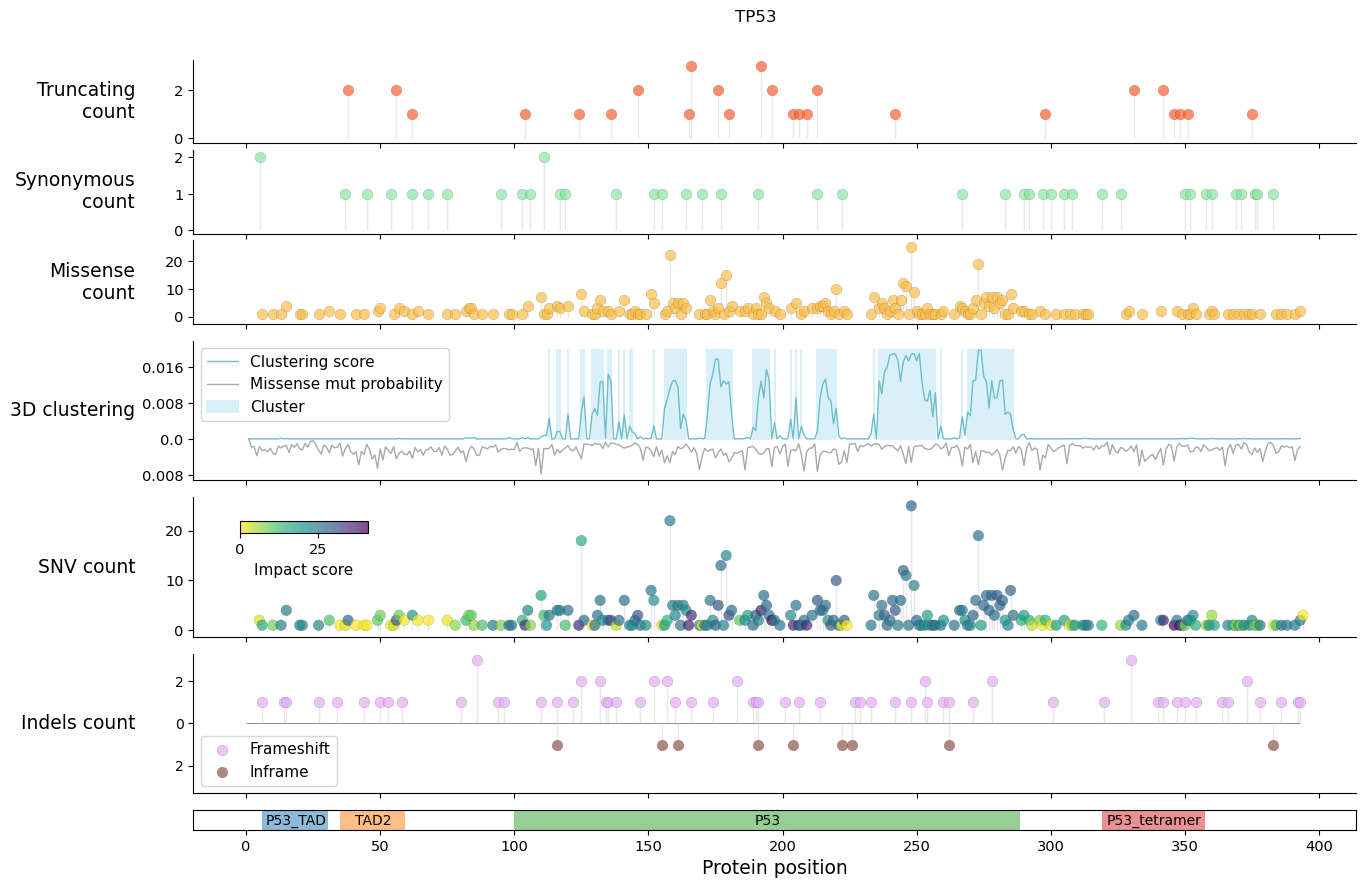

In [11]:
for gene in ["TP53"]: #, "CDKN1A"]:
    plot_pars = init_plot_pars()        
    generate_plot(gene, 
                  o3d_seq_df,
                  o3d_annot_df,
                  o3d_prob,
                  o3d_score,
                  maf_df_f, 
                  snv_df, 
                  trunc_df, 
                  synon_df, 
                  miss_df,
                  plot_pars,
                  output_path=plots_dir,
                  clustering_full_filling=True)

In [12]:
# !rm Fig3_plots/Fig3b/*.png

# Side plots

In [15]:
def build_counts_from_df_complete(genee, snvs_maf, omega_truncating, omega_missense):

    trunc_omega = float(omega_truncating[omega_truncating["GENE"] == genee]["omega_trunc"].values[0])
    trunc_pvalue = float(omega_truncating[omega_truncating["GENE"] == genee]["pvalue"].values[0])

    miss_omega = float(omega_missense[omega_missense["GENE"] == genee]["omega_mis"].values[0])
    miss_pvalue = float(omega_missense[omega_missense["GENE"] == genee]["pvalue"].values[0])
    snvs_gene = snvs_maf[snvs_maf["SYMBOL"] == genee].reset_index(drop = True)


    # Calculate counts based on canonical consequences
    truncating_count = snvs_gene[snvs_gene["canonical_Consequence_broader"].isin(['nonsense', "essential_splice"])].shape[0]
    missense_count = snvs_gene[snvs_gene["canonical_Consequence_broader"].isin(['missense'])].shape[0]
    synonymous_count = snvs_gene[snvs_gene["canonical_Consequence_broader"].isin(["synonymous"])].shape[0]

    # Compute 
    expected_missense = (1 - ((miss_omega - 1) / miss_omega)) * missense_count
    expected_truncating = (1 - ((trunc_omega - 1) / trunc_omega)) * truncating_count


    # Create a dataframe from the counts and expected values
    data = {
        'type': ['truncating', 'synonymous', 'missense'],
        'number_obs': [truncating_count, synonymous_count, missense_count],
        'expected': [expected_truncating, None, expected_missense],
        'omega': [trunc_omega, None, miss_omega],
        'pvalue': [trunc_pvalue, None, miss_pvalue]
    }
    df = pd.DataFrame(data)

    # Print the final dataframe
    return df




def plot_omega_side_complete(df):

    consequence_order = ['truncating', "synonymous", "missense"]

    # Define colors for each type
    colors = {
        'truncating': metrics_colors_dictionary["omega_trunc"],
        'missense': metrics_colors_dictionary["omega_miss"],
        'synonymous': metrics_colors_dictionary["omega_synon"]
    }
    
    t_omega = df[df['type'] == 'truncating']['omega'].item()
    t_pvalue = df[df['type'] == 'truncating']['pvalue'].item()
    m_omega = df[df['type'] == 'missense']['omega'].item()
    m_pvalue = df[df['type'] == 'missense']['pvalue'].item()
    
    
    # Plot for truncating, missense, and synonymous
    # fig, ax = plt.subplots(figsize=(4, 2))
    fig, ax = plt.subplots(figsize=(3.4, 2))

#     # Bar positions
#     y_positions = np.arange(len(consequence_order)) * 2  # Add separation between bars

#     # Plot the observed values as filled bars
#     for i, cons in enumerate(consequence_order):
#         obs_value = df[df['type'] == cons]['number_obs'].values[0]
#         ax.barh(y_positions[i], obs_value, color=colors[cons], label=cons)

    # Plot the observed values as filled bars
    sns.barplot(data=df, y='type', x='number_obs',
                hue = 'type', legend = False,
                hue_order = consequence_order,
                order=consequence_order, palette=[colors[x] for x in consequence_order],
                ax = ax
                )

    # Overlay the expected values with shaded portions
    leg = True
    for i, row in df.iterrows():
        if row['expected'] is not None:
            # plt.barh(row['type'], row['expected'], color='gray', alpha=0.5, edgecolor='none')
            # plt.barh(row['type'], row['expected'], color='none', edgecolor=colors[row['type']], hatch='//', linewidth=0)
            if leg:
                ax.barh(row['type'], row['expected'], color='none', edgecolor="gray", hatch='////', linewidth=0, label = 'expected')
                leg = False
            else:
                ax.barh(row['type'], row['expected'], color='none', edgecolor="gray", hatch='////', linewidth=0)



    # Remove the right and top spines
    # ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Customize the ticks and labels
    ax.xaxis.set_ticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])


    # Text annotations
    text_separation = max(df['number_obs']) * 0.03
    deviation_for_centering = text_separation * 12
    
    # text_of_line_separation = line_separation / 3
    text_pos1 = max(df[df['type'].isin(consequence_order[:2])]['number_obs']) + text_separation + deviation_for_centering
    text_pos2 = max(df[df['type'].isin(consequence_order[1:])]['number_obs']) + text_separation + deviation_for_centering
    # print(text_pos1, text_pos2)
    
    ax.text(text_pos1, 0.05,
            # r'$\omega_{trunc}$ = ' + f"{t_omega:.2f}",
            r'$dN/dS_{trunc}$ = ' + f"{t_omega:.2f}",
            # transform=ax.transAxes,
            fontsize=13, ha='center', va='bottom',
            color=colors['truncating'])
                   #f'$p$-value = {p_value:.2g}')

    ax.text(text_pos1, 0.45, f'$p$-value < {max(t_pvalue, 1e-6):.1e}',
            # transform=ax.transAxes,
            fontsize=12, ha='center', va='bottom',
            color=colors['truncating'])

    ax.text(text_pos2, 1.95,
            # r'$\omega_{mis}$ = ' + f"{m_omega:.2f}",
            r'$dN/dS_{mis}$ = ' + f"{m_omega:.2f}",
            # transform=ax.transAxes,
            fontsize=13, ha='center', va='bottom',
            color=colors['missense'])
    ax.text(text_pos2, 2.35, f'$p$-value < {max(m_pvalue, 1e-6):.1e}',
            # transform=ax.transAxes,
            fontsize=12, ha='center', va='bottom',
            color=colors['missense'])

    # Update labels
    plt.xlabel('Number of Mutations')
    # plt.xscale('log')
    plt.ylabel('')
    plt.legend(loc='right', frameon=False)
    # plt.legend(loc='right', frameon=False, fontsize=12, handlelength=3, markerscale=2)  # Increase legend text and marker size
    # plt.show()
    return fig

In [16]:
def plot_oncodrivefml_side(geneee_data):
    legend_fontsize = 12
    xaxis_fontsize = 12
    
    # Extract the necessary values
    observed_mean = geneee_data['OBSERVED_MEAN']
    background_mean = geneee_data['BACKGROUND_MEAN']
    background_std = geneee_data['BACKGROUND_STD']
    p_value = geneee_data['pvalue']

    observed_color = metrics_colors_dictionary["ofml_score"]
    
    deviation = abs(observed_mean - background_mean)

    # Calculate the Z-score
    z_score = (observed_mean - background_mean) / background_std
        
    # Generate a range of values for the x-axis
    x = np.linspace(background_mean - 1*background_std - deviation, background_mean + 1*background_std + deviation, 1000)
    # Generate the normal distribution based on background mean and std
    y = norm.pdf(x, background_mean, background_std)

    # Compute half of the maximum value
    mid_y = max(y) / 2
    
    # Plot the normal distribution vertically
    # fig, ax = plt.subplots(figsize=(3, 1.75))
    fig, ax = plt.subplots(figsize=(4, 1.5))

    background_color = 'dimgrey'
    background_color_line = 'dimgrey'
    ax.plot(x, y, color = background_color)
    ax.fill_betweenx(y, x, color = background_color, alpha=0.2) #, label = 'Randomized\nmeans' )
    
    # Arrows with annotations
    arrow_props = dict(facecolor= observed_color, edgecolor = observed_color, arrowstyle='<->')

    if z_score > 0:
        ax.set_xlim(background_mean - (1*background_std + deviation) / 2, background_mean + (1*background_std + deviation))
        # ax.text(background_mean + background_std, mid_y * 1.75, f'Randomized\nmeans', color=background_color, ha='left', va='top')
        #ax.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.2, 1.1), labelcolor = background_color)
        
        # # Set integer tick labels on the x-axis
        # x_ticks = np.linspace(background_mean - (1*background_std + deviation) / 2, background_mean + (1*background_std + deviation), num=3)
        # x_ticks_int = np.round(x_ticks).astype(int)
        # ax.set_xticks(x_ticks_int)

        # Arrow 1
        ax.annotate('', xy=(background_mean, mid_y), xytext=(observed_mean, mid_y), arrowprops=arrow_props)
        
    else:
        ax.set_xlim(background_mean - (1*background_std + deviation), background_mean + (1*background_std + deviation) / 2)
        # ax.text(background_mean - background_std, mid_y * 1.75, f'Randomized\nmeans', color=background_color, ha='left', va='top')
        # Add legend without border
        #ax.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.2, 1.1), labelcolor = background_color)

        # # Set integer tick labels on the x-axis
        # x_ticks = np.linspace(background_mean - (1*background_std + deviation), background_mean + (1*background_std + deviation) / 2, num=3)
        # x_ticks_int = np.round(x_ticks).astype(int)
        # ax.set_xticks(x_ticks_int)

        # Arrow
        ax.annotate('', xy=(background_mean, mid_y), xytext=(observed_mean, mid_y), arrowprops=arrow_props)

        
        
    # Legend
    legend_handles = [Patch(facecolor=background_color_line, alpha=0.2, edgecolor='none', label='Randomized means'),
                      Line2D([0], [0], color="black", linestyle='--', label='Observed mean')]
    legend = ax.legend(handles=legend_handles, frameon=False, loc='upper right', bbox_to_anchor=(1.6, 1.1), fontsize=legend_fontsize)

    # Adjust the color of the text labels in the legend
    for text, color in zip(legend.get_texts(), ["black", "black"]):
        text.set_color(color)
       
        
    ax.set_xticks([])
        
    # Add a vertical line for the observed mean
    ax.axvline(observed_mean, color="black", linestyle='--', ymin=0, ymax=0.5, label="Observed mean")
    
    # Add a label for the observed mean
    if p_value == 1e-6:
        #ax.text(observed_score*1.1, max(y)/2, text, ha='left', va='center', fontsize=text_fontsize, color=observed_color)
        #ax.text(observed_score*1.1, max(y)/2 - 0.35*(max(y)/2), fr'$\mathit{{p}}$-value < {pvalue}', ha='left', va='center', fontsize=text_fontsize, color=observed_color)
        ax.text(observed_mean * 1.03, mid_y, f'$Score$ = {z_score:.2f}',
                color=observed_color, ha='left', va='center', fontsize = 13)
        ax.text(observed_mean * 1.03, mid_y - 0.35*mid_y, f'$p$-value < {p_value:.2g}',
                color=observed_color, ha='left', va='center', fontsize = 13)
    else:
        ax.text(observed_mean * 1.03, mid_y, f'$Score$ = {z_score:.2f}',
                color=observed_color, ha='left', va='center', fontsize = 13)
        ax.text(observed_mean * 1.03, mid_y - 0.35*mid_y, f'$p$-value = {p_value:.2g}',
                color=observed_color, ha='left', va='center', fontsize = 13)

    # Set labels and title
    ax.set_xlabel('Impact score', fontsize = xaxis_fontsize)

    # Hide the bottom, right, and top borders (spines) of the plot
    for spine in ['left', 'right', 'top']:
        ax.spines[spine].set_visible(False)

    # Hide the entire y-axis
    ax.yaxis.set_visible(False)

    # Display the plot
    plt.show()
    
    
    
#     # Annotate the Z-score, formula and p-value with LaTeX
#     formula = (f'$Z = \\frac{{{observed_mean:.2f} - {background_mean:.2f}}}{{{background_std:.2f}}} = {z_score:.2f}$\n'
#                f'$p$-value = {p_value:.2g}')
#     plt.text(observed_mean - 2, mid_y * 1.25, formula, 
#              color='black', ha='center', va='center')    

    return fig



In [17]:
def plotting_indels_side(data_gene):

    # Bar labels and values
    labels = ['MULTIPLE_3.non_protein_affecting', 'NOT_MULTIPLE_3.non_protein_affecting',
              'NON_TRUNCATING.protein_affecting', 'TRUNCATING.protein_affecting']
    values = [ data_gene[x] for x in labels ]

    # Colors:
    truncating_indels_color = metrics_colors_dictionary["frameshift"]
    nontruncating_color = metrics_colors_dictionary["inframe"]
    colors = ['none', 'none', nontruncating_color, truncating_indels_color]
    edgecolors = [nontruncating_color, truncating_indels_color, nontruncating_color, truncating_indels_color]

    # Create the plot with a smaller height
    fig, ax = plt.subplots(figsize=(4.365, 1.5))  # Adjust the height and width

    # Plot the bars horizontally with the specified colors and hatches
    bars = ax.barh(labels, values, color=colors, edgecolor=edgecolors, linewidth = 2)

    # Remove the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


    max_syn = max(values) * 1.55

    # Vertical lines
    line_separation = max(values) * 0.03
    text_of_line_separation = line_separation # / 2
    line_pos1 = max(values[:2]) + line_separation
    line_pos2 = max(values[2:]) + line_separation
    line_margin = 0.04
    ax.axvline(x=line_pos1, ymin = line_margin, ymax = 0.5 - line_margin, color='black',
               # linestyle='--',
               linewidth=1)
    ax.axvline(x=line_pos2, ymin = 0.5 + line_margin, ymax = 1 - line_margin, color='black',
               # linestyle='--',
               linewidth=1)

    # Annotation for "PA" and "NPA" next to vertical lines
    ax.text(line_pos1 + 2.2*text_of_line_separation, 0.5, 'Non\ncoding', ha='center', va='center', fontsize=9,
            rotation = 270
           )
    ax.text(line_pos2 + text_of_line_separation, 2.5, 'Coding', ha='center', va='center', fontsize=9,
            rotation = 270
           )


    # formula_ratio = (f'$\\frac{{{data_gene["pa_TRUNC/NOTTRUNC"]:.2f}}}{{{data_gene["Npa_NM3/M3"]:.2f}}} = {data_gene["pa/Npa"]:.2f}$')
    # formula_ratio = (f'$\\frac{{{data_gene["pa_TRUNC/NOTTRUNC"]:.2f}}}{{{data_gene["Npa_NM3/M3"]:.2f}}} = {data_gene["pa/Npa"]:.2f}$')
    ax.text(max_syn, 1.5, f'$Score$ = {data_gene["pa/Npa"]:.2f}',
            color=truncating_indels_color, ha='center', va='center', fontsize = 13)

    pvalue_tag = f'$p$-value = {data_gene["pvalue"]:.2g}'
    ax.text(max_syn, 0.8, pvalue_tag,
            color=truncating_indels_color,
            fontsize=12, ha='center', va='center'
           )

    # Add title and labels
    ax.set_xlabel('Count')

    # Customize the ticks and labels
    ax.xaxis.set_ticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Update labels
    plt.xlabel('Number of indels')
    plt.ylabel('')

    return fig


In [18]:
def generate_all_side_figures(sample, 
                              run_dir,
                              gene_list = None,
                              store_plots_dir = None,
                              tools = ["oncodrivefml", "oncodrive3d", "omega_trunc", "omega_mis", "excess_indels"]):
    maf_file = f"{run_dir}/somaticmutations/all_samples.somatic.mutations.tsv"
    maf_df = pd.read_csv(maf_file, sep = "\t", header = 0)
    maf_df_f = maf_df[~(maf_df['FILTER'].str.contains("not_in_panel"))].reset_index(drop = True)
    snvs_maf = maf_df_f[(maf_df_f['TYPE'] == 'SNV')
                    & (maf_df_f["canonical_CDS_position"] != '-')
                   ].reset_index(drop = True)
    snvs_maf["canonical_CDS_position"] = snvs_maf["canonical_CDS_position"].astype(int)
    
    
    possible_genes = []
    if "oncodrivefml" in tools:
        oncodrivefml_data = pd.read_table(f"{run_dir}/oncodrivefmlsnvs/{sample}.all/{sample}-oncodrivefml.tsv.gz")
        oncodrivefml_data = oncodrivefml_data[["GENE_ID", "Z-SCORE", "Q_VALUE", "AVG_SCORE_OBS", "POPULATION_MEAN", "STD_OF_MEANS"]]
        oncodrivefml_data.columns = ["GENE", "OncodriveFML", "pvalue", "OBSERVED_MEAN", "BACKGROUND_MEAN", "BACKGROUND_STD"]
        possible_genes += list(pd.unique(oncodrivefml_data["GENE"]))


    if "omega_trunc" in tools or "omega_mis" in tools:
        omega_data = pd.read_table(f"{run_dir}/omega/output_mle.{sample}.tsv")
        omega_data = omega_data[omega_data["impact"].isin(['missense', 'truncating'])]
        if "omega_trunc" in tools :
            omega_truncating = omega_data[omega_data["impact"] == "truncating"].reset_index(drop = True)[["gene", "dnds", "pvalue", "lower", "upper"]]
            omega_truncating.columns = ["GENE", "omega_trunc", "pvalue", "lower", "upper"]
            possible_genes += list(pd.unique(omega_truncating["GENE"]))
            
        if "omega_mis" in tools :
            omega_missense = omega_data[omega_data["impact"] == "missense"].reset_index(drop = True)[["gene", "dnds", "pvalue", "lower", "upper"]]
            omega_missense.columns = ["GENE", "omega_mis", "pvalue", "lower", "upper"]
            possible_genes += list(pd.unique(omega_missense["GENE"]))

            
    if "excess_indels" in tools:
        indels_data = pd.read_table(f"{run_dir}/indels/{sample}.sample.indels.tsv",
                                    sep = '\t',
                                    header = 0)
   
    if gene_list is not None:
        gene_list = list(set(gene_list))
    else:
        # gene_list = list(pd.unique(oncodrivefml_data["GENE"]))
        gene_list = list(set(possible_genes))
        


    for genee in gene_list:
        print(genee)
        
        # Select the specific gene data
        oncodrivefml_gene_data = oncodrivefml_data[oncodrivefml_data["GENE"] == genee].to_dict(orient='records')[0]

        fig_gene_fml = plot_oncodrivefml_side(oncodrivefml_gene_data)

        if store_plots_dir is not None:
            fig_gene_fml.savefig(f"{store_plots_dir}/{genee}.oncodrivefml_side.png", dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
        
        omega_df = build_counts_from_df_complete(genee, snvs_maf, omega_truncating, omega_missense)
        
        fig_gene_omega = plot_omega_side_complete(omega_df)
        if store_plots_dir is not None:
            fig_gene_omega.savefig(f"{store_plots_dir}/{genee}.omega_side.png", dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
        
        
        indel_data_gene = indels_data[indels_data["SYMBOL"] == genee].to_dict(orient='records')[0]
        fig_gene_indel = plotting_indels_side(indel_data_gene)
        if store_plots_dir is not None:
            fig_gene_indel.savefig(f"{store_plots_dir}/{genee}.indels_side.png", dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
        
        print("\n\n\n")
        # break

In [19]:
deepcsa_run_dir

'/data/bbg/nobackup/bladder_ts/results/2025-03-28_deepCSA'

/tmp/ipykernel_2601006/2045019895.py:7: DtypeWarning: Columns (49,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  maf_df = pd.read_csv(maf_file, sep = "\t", header = 0)


TP53


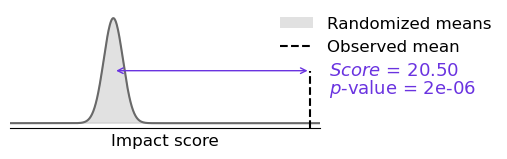

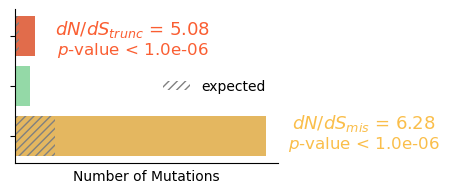

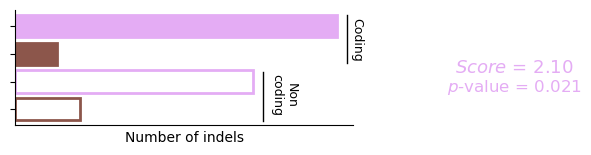





CDKN1A


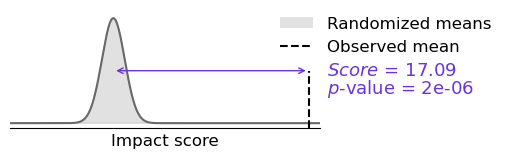

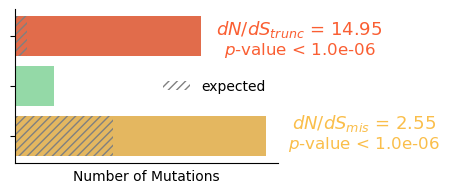

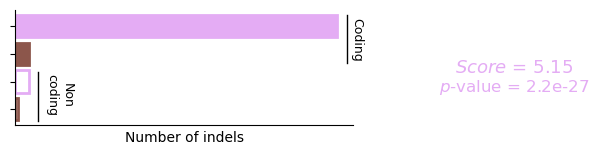

In [20]:
generate_all_side_figures("all_samples", deepcsa_run_dir,
                          gene_list = ['TP53', 'CDKN1A'],
                          store_plots_dir = f"plot"
                           # store_plots_dir = f"{plots_dir}"
                         )

### Summary scores data

In [22]:
# def get_summary_score(df, score_col, gene):
    
#     score, pvalue = df.loc[df["GENE"] == gene, [score_col, "pvalue"]].values[0]
    
#     return score, pvalue

# mut_score_df = pd.read_table(f"{fig3_data}/mutations_scored.TP53.tsv")
# indels_score_df = pd.read_table(f"{fig3_data}/indels.results.tsv")
# omega_misss_score_df = pd.read_table(f"{fig3_data}/omega_missense.results.tsv")
# omega_truncating_score_df = pd.read_table(f"{fig3_data}/omega_truncating.results.tsv")
# o3d_score_df = pd.read_table(f"{fig3_data}/oncodrive3d.results.tsv")
# ofml_score_df = pd.read_table(f"{fig3_data}/oncodrivefml.results.tsv")

# indels_score, indels_pvalue = get_summary_score(indels_score_df, "Indels_score", gene)
# omega_misss_score, omega_misss_pvalue = get_summary_score(omega_misss_score_df, "omega_mis", gene)
# omega_truncating_score, omega_truncating_pvalue = get_summary_score(omega_truncating_score_df, "omega_trunc", gene)
# o3d_score, o3d_pvalue = get_summary_score(o3d_score_df, "Oncodrive3D", gene)
# ofml_score, ofml_pvalue = get_summary_score(ofml_score_df, "OncodriveFML", gene)

# o3d_pvalue = 1 / 10000 if o3d_pvalue == 0 else o3d_pvalue
# indels_pvalue = 1 / 1000000 if indels_pvalue == 0 else indels_pvalue
# omega_misss_pvalue = 1 / 1000000 if omega_misss_pvalue == 0 else omega_misss_pvalue
# omega_truncating_pvalue = 1 / 1000000 if omega_truncating_pvalue == 0 else omega_truncating_pvalue
# ofml_pvalue = 1 / 1000000 if ofml_pvalue == 0 else ofml_pvalue

### O3D summary data

In [23]:
gene = "TP53"

# Subset gene
o3d_seq_df_gene = o3d_seq_df[o3d_seq_df["Gene"] == gene]
gene_len = len(o3d_seq_df_gene.Seq.values[0])
pos_gene = pd.DataFrame({"Pos" : range(1, gene_len+1)})
uni_id, af_f = o3d_seq_df_gene[["Uniprot_ID", "F"]].values[0]
o3d_score = f"{deepcsa_run_dir}/oncodrive3d/run/{run_name}/{run_name}.3d_clustering_pos.csv"
o3d_score = pd.read_csv(o3d_score)[["Gene", "Pos", "Score", "Score_obs_sim", "pval", "C", "C_ext"]]
o3d_score_gene = o3d_score[o3d_score["Gene"] == gene].reset_index(drop=True)

# Since it is just a toy example, take the Observed score of the top rank
# and the Score_obs_sim of the top volume
o3d_top_score_gene = o3d_score_gene.Score.values[0]
o3d_top_pos_score_gene = o3d_score_gene.sort_values(["pval", "Score_obs_sim"], ascending=[True, False]).Score_obs_sim.values[0]

## Last iter (toy on TP53)

Saving Fig3_plots/Fig3b/side_plot_toy_tp53.png


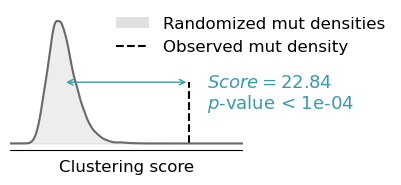

In [577]:
from scipy.stats import lognorm
from matplotlib.lines import Line2D


def get_toy_sim_vector(sim_vec, scale=0.002):
    
    shape, loc, _ = lognorm.fit(sim_vec, floc=0)
    toy_vec = lognorm.rvs(shape, loc, scale, size=(1, 10000)).flatten()
    
    return toy_vec


def plot_o3d_side_plot(sim_score_vec,
                       observed_score,
                       o3d_top_pos_score_gene,
                       pvalue,
                       scale=0.017,
                       figsize=(3, 1.75),
                       label_fontsize=12,
                       legend_fontsize=12,
                       text_fontsize=12,
                       background_color_fill="darkgray",
                       background_color_line="dimgrey",
                       observed_color="#3b99aa",
                       output_path=None):
    
    
    toy_sim_vec = get_toy_sim_vector(sim_score_vec, scale=0.017)

    fig, ax = plt.subplots(figsize=figsize)

    # Plot DKE and extract data
    kde = sns.kdeplot(x=toy_sim_vec, ax=ax, color=background_color_fill, linewidth=0.1)
    x, y = kde.get_lines()[0].get_data()

    # Plot the fill and extended line
    x_min, x_max = 0, 0.075
    x_extended = np.concatenate(([x_min - (x_max - x_min) * 0.05], x, [x_max + (x_max - x_min) * 0.05]))
    y_extended = np.concatenate(([0], y, [0]))
    ax.fill_betweenx(y, x, color = background_color_fill, alpha=0.2, label="Randomized mut densities")
    ax.plot(x_extended, y_extended, color=background_color_line)
    ax.vlines(observed_score, ymin=0, ymax=max(y)/2, color="black", zorder=1, linestyle='--', label="Observed mut density")

    # Details
    ax.set_ylim(-0.05 * max(y), max(y) * 1.05)
    ax.set_xlim(0.0005, x_max)
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.yaxis.set_visible(False)
    plt.ylabel(None)
    plt.xlabel("Clustering score", fontsize=label_fontsize)

    for spine in ['left', 'right', 'top']:
        ax.spines[spine].set_visible(False)

    # Arrow
    arrow_props = dict(facecolor= observed_color, edgecolor = observed_color, arrowstyle='<->')
    ax.annotate('', xy=(np.mean(toy_sim_vec), max(y)/2), xytext=(observed_score, max(y)/2), arrowprops=arrow_props)

    # Legend
    legend_handles = [Patch(facecolor=background_color_line, alpha=0.2, edgecolor='none', label='Randomized mut densities'),
                      Line2D([0], [0], color="black", linestyle='--', label='Observed mut density')]
    legend = ax.legend(handles=legend_handles, frameon=False, loc='upper right', bbox_to_anchor=(1.677, 1.1), fontsize=legend_fontsize)

    # Adjust the color of the text labels in the legend
    for text, color in zip(legend.get_texts(), ["black", "black"]):
        text.set_color(color)

    text = fr'$\mathit{{Score}} = {np.round(o3d_top_pos_score_gene, 2)}$'
    ax.text(observed_score*1.1, max(y)/2, text, ha='left', va='center', fontsize=text_fontsize+1, color=observed_color)
    pvalue = "{:.0e}".format(pvalue)
    ax.text(observed_score*1.1, max(y)/2 - 0.35*(max(y)/2), fr'$\mathit{{p}}$-value < {pvalue}', ha='left', va='center', 
            fontsize=text_fontsize+1, color=observed_color)

    if output_path is not None:
        print(f"Saving {output_path}")
        plt.savefig(output_path, bbox_inches='tight')
        
    plt.show()
    
o3d_temp_data = "/home/spellegrini/TEMP_DATA"
sim_score = pd.read_csv(f"{o3d_temp_data}/TP53_simulated_scores.csv")
sim_score = sim_score.drop(columns=["index"])[:1].values[0]

plot_o3d_side_plot(sim_score,
                   o3d_top_score_gene,
                   o3d_top_pos_score_gene,
                   o3d_pvalue,
                   scale=0.017,
                   figsize=(3, 1.75),
                   label_fontsize=12,
                   legend_fontsize=12,
                   text_fontsize=12,
                   output_path="plot/side_plot_toy_tp53.png")


## O3D structure

open AF-P04637-F1-model_v4.pdb
color lightgray
graphics silhouettes true width 1.3

use marker_command to create cluste markers

lighting soft
zoom
save /home/spellegrini/PhD/Projects/Oncodrive3D/normal_tissue/bladder/tp53_i0.png pixelSize 0.08 supersample 3 transparentBackground true

In [1105]:
o3d_score_gene[o3d_score_gene.Cluster == 1].Pos.values

array([113, 116, 120, 125, 126, 127, 129, 130, 131, 132, 133, 135, 136,
       138, 139, 141, 142, 143, 144, 145, 152, 154, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 168, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 189, 190, 192, 193, 194, 195, 196, 197, 203, 205,
       213, 214, 215, 216, 217, 218, 219, 220, 232, 233, 234, 235, 236,
       237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249,
       250, 251, 252, 253, 254, 255, 257, 259, 267, 269, 270, 271, 272,
       273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285])

In [1107]:
marker_command = ""
for pos in o3d_score_gene[o3d_score_gene.Cluster == 1].Pos.values:
    
    text += f"marker #15 position :{pos} color #87CEEB35 radius 5.919;"

In [1108]:
marker_command

'marker #15 position :113 color #87CEEB35 radius 5.919;marker #15 position :116 color #87CEEB35 radius 5.919;marker #15 position :120 color #87CEEB35 radius 5.919;marker #15 position :125 color #87CEEB35 radius 5.919;marker #15 position :126 color #87CEEB35 radius 5.919;marker #15 position :127 color #87CEEB35 radius 5.919;marker #15 position :129 color #87CEEB35 radius 5.919;marker #15 position :130 color #87CEEB35 radius 5.919;marker #15 position :131 color #87CEEB35 radius 5.919;marker #15 position :132 color #87CEEB35 radius 5.919;marker #15 position :133 color #87CEEB35 radius 5.919;marker #15 position :135 color #87CEEB35 radius 5.919;marker #15 position :136 color #87CEEB35 radius 5.919;marker #15 position :138 color #87CEEB35 radius 5.919;marker #15 position :139 color #87CEEB35 radius 5.919;marker #15 position :141 color #87CEEB35 radius 5.919;marker #15 position :142 color #87CEEB35 radius 5.919;marker #15 position :143 color #87CEEB35 radius 5.919;marker #15 position :144 co

# Plot all genes or other details

> KMT2D - ENST00000301067 - ENST00000301067 - O14686
Saving Fig3_plots/Fig3b/KMT2D_alt_clust_filling.png


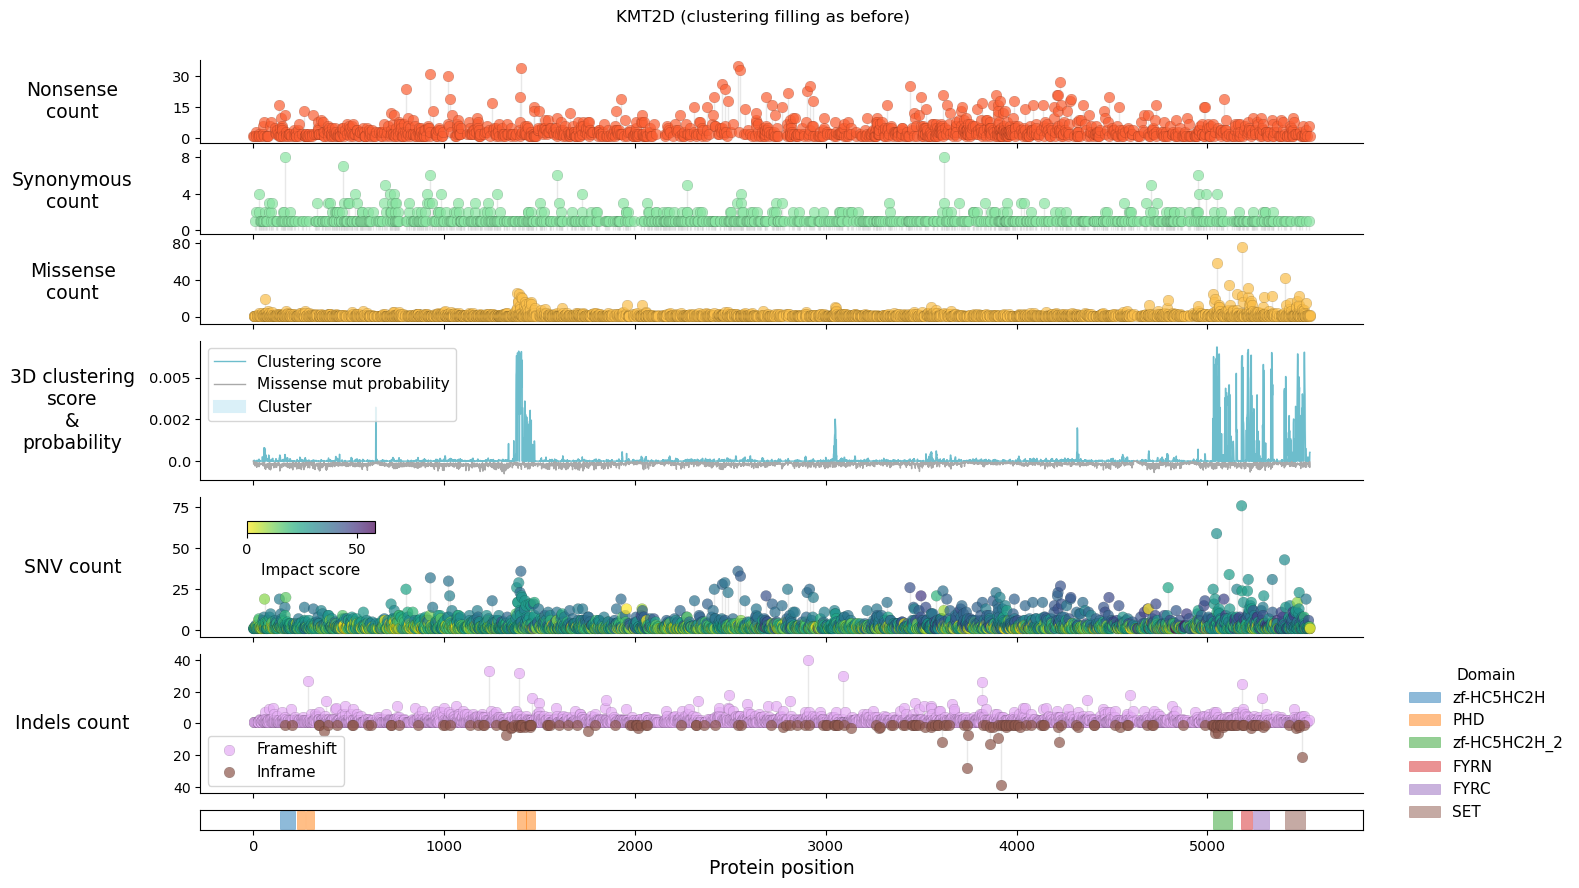

> EP300 - ENST00000263253 - ENST00000263253 - Q09472
Saving Fig3_plots/Fig3b/EP300_alt_clust_filling.png


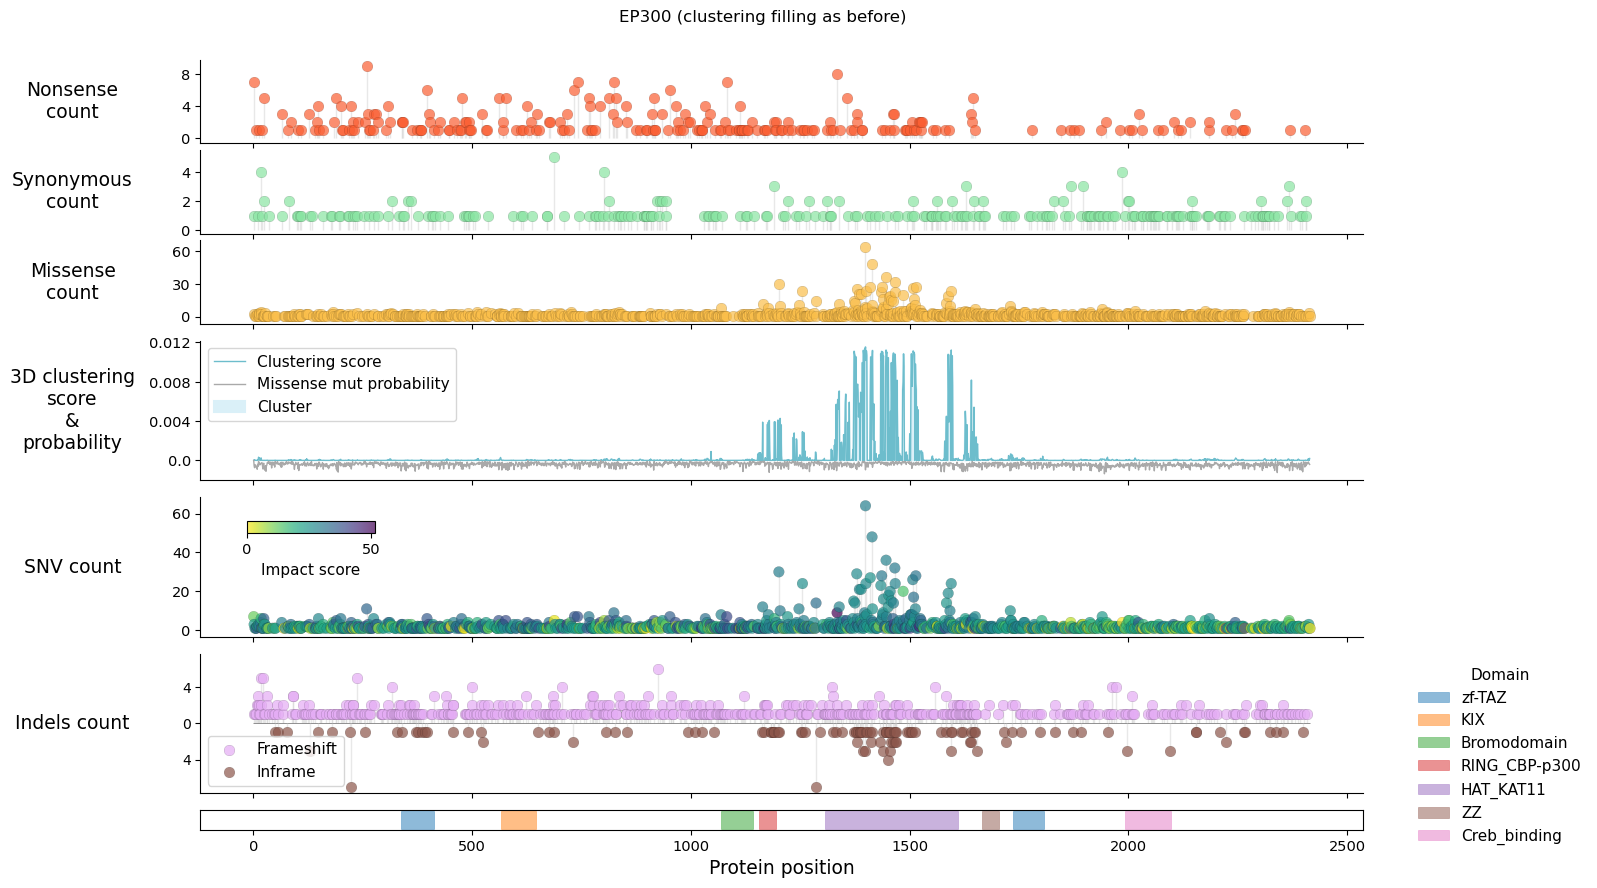

> ARID1A - ENST00000324856 - ENST00000324856 - O14497
Saving Fig3_plots/Fig3b/ARID1A_alt_clust_filling.png


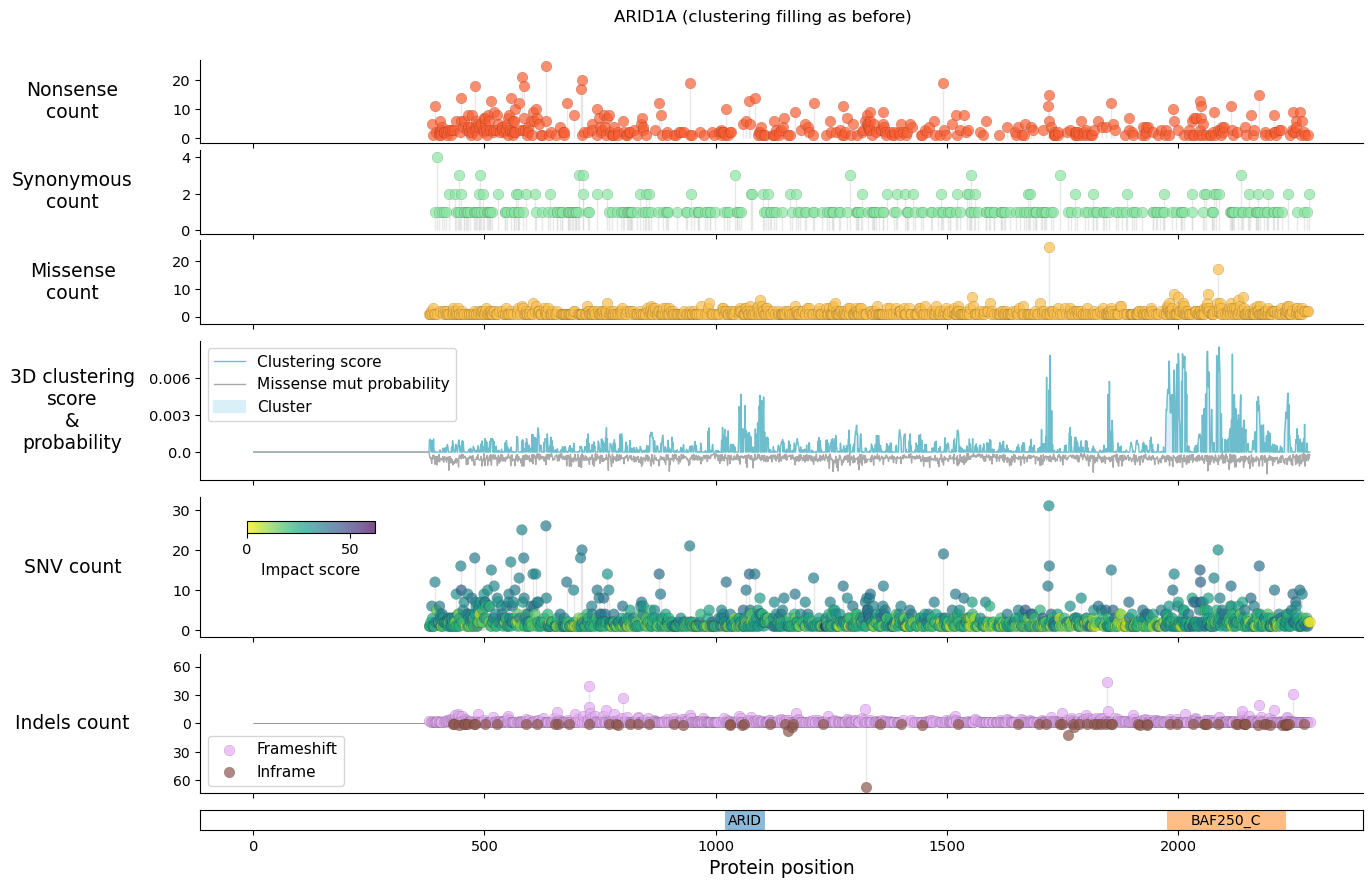

> CREBBP - ENST00000262367 - ENST00000262367 - Q92793
Saving Fig3_plots/Fig3b/CREBBP_alt_clust_filling.png


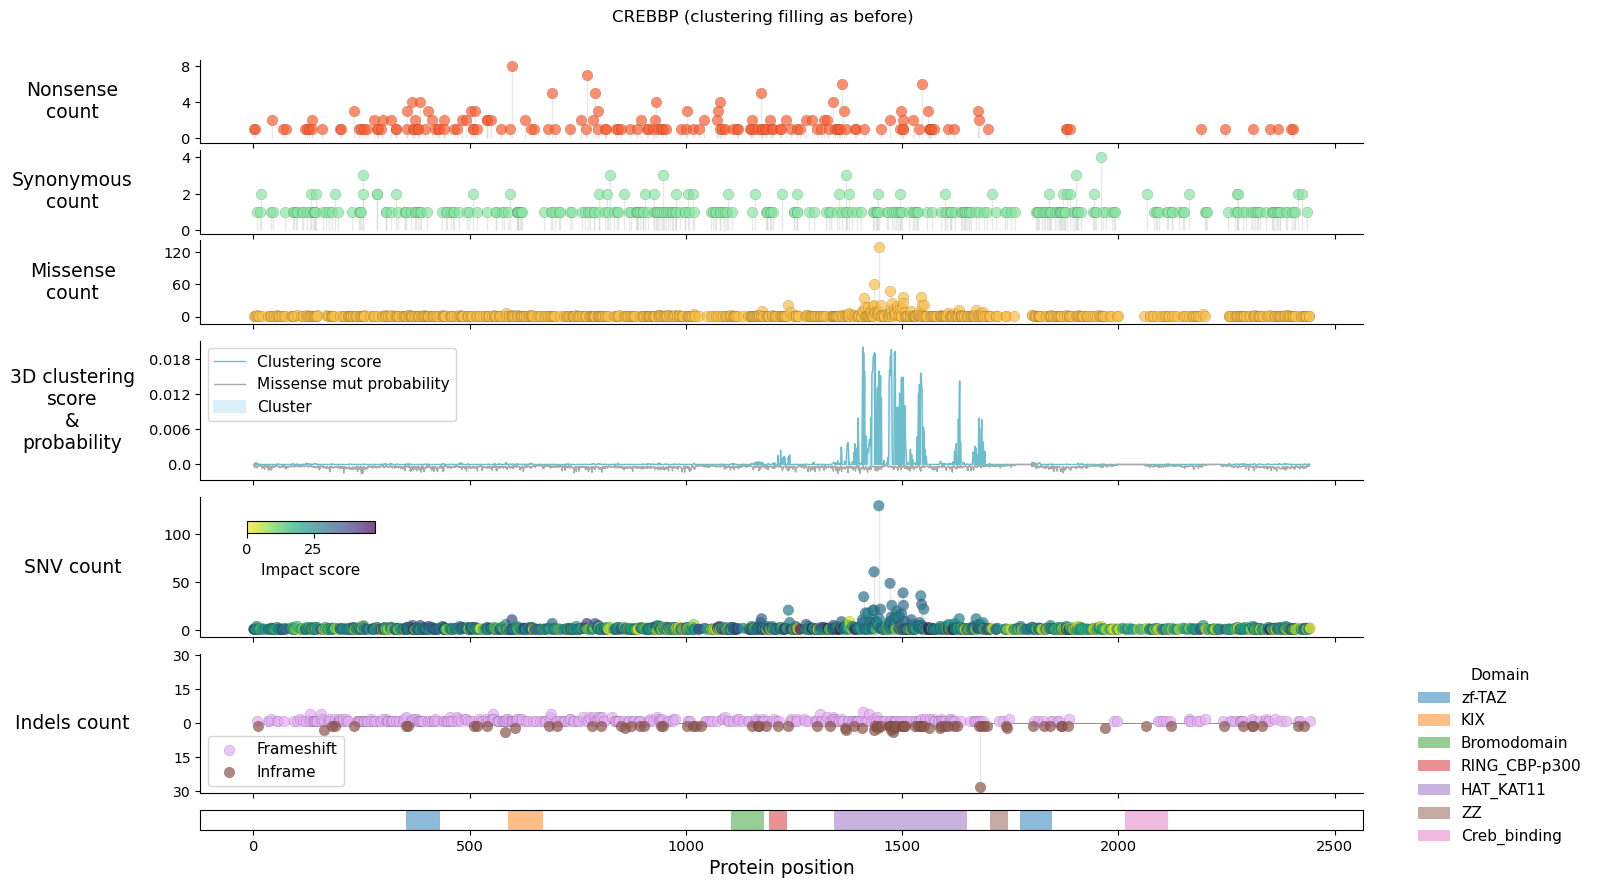

> NOTCH2 - ENST00000256646 - ENST00000256646 - Q04721
Saving Fig3_plots/Fig3b/NOTCH2_alt_clust_filling.png


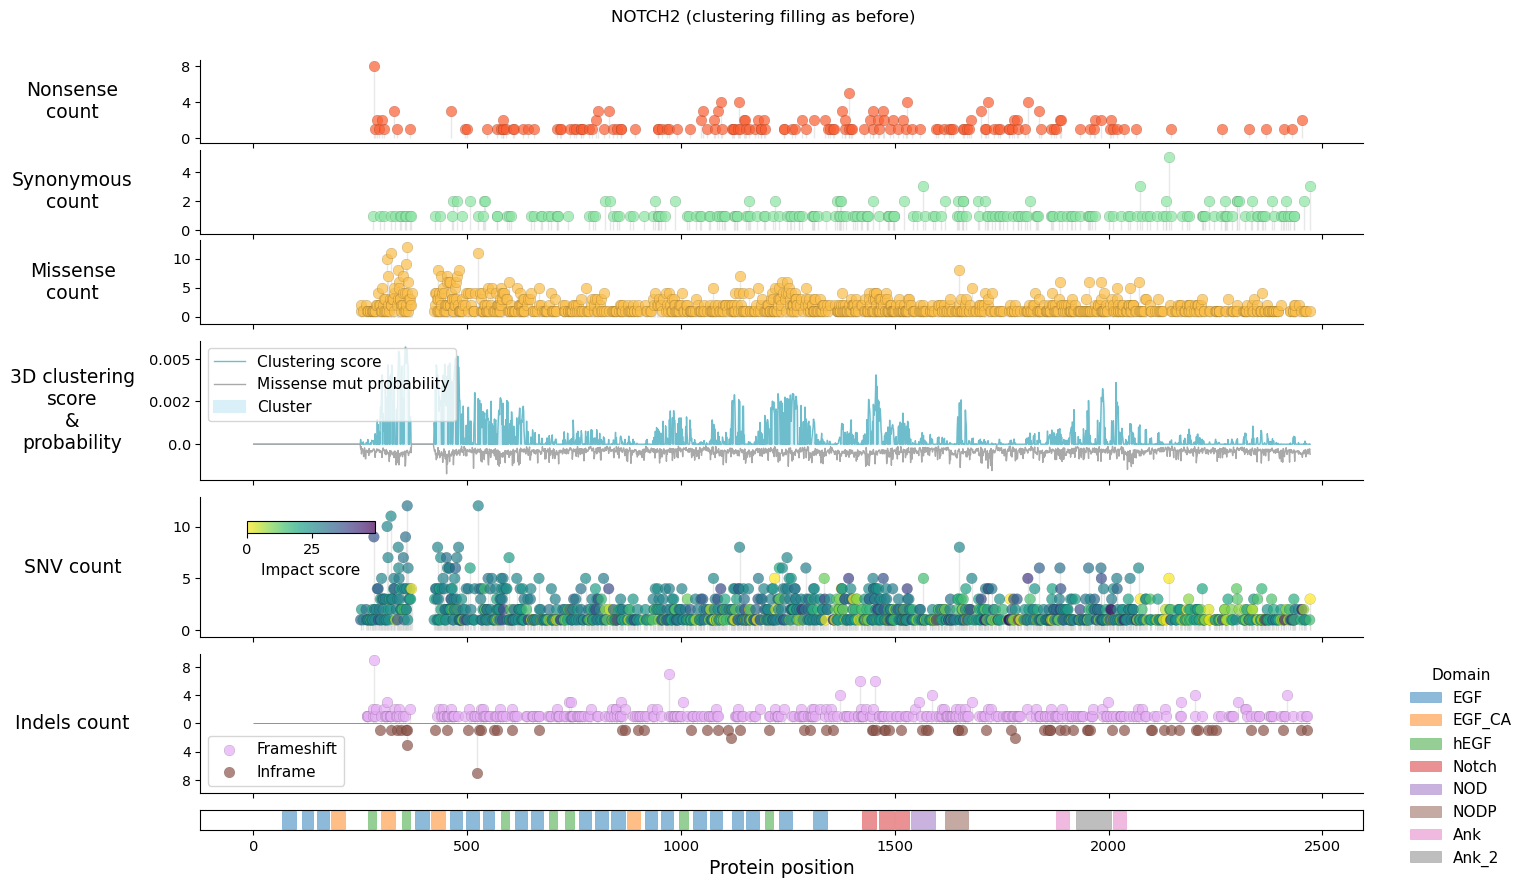

> KMT2C - ENST00000262189 - ENST00000262189 - Q8NEZ4
Saving Fig3_plots/Fig3b/KMT2C_alt_clust_filling.png


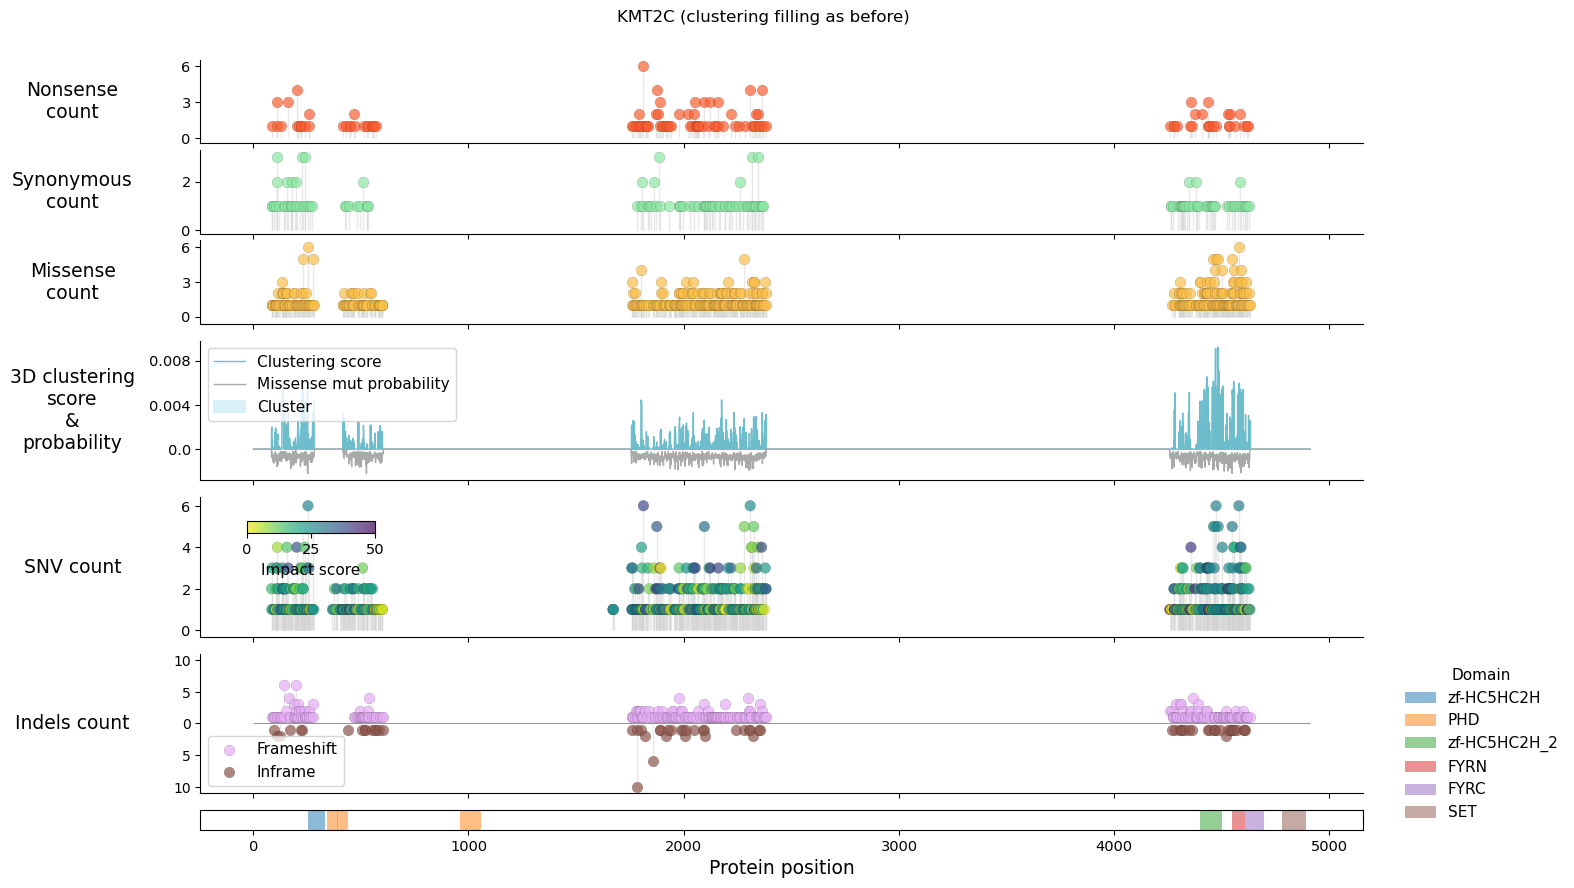

> RB1 - ENST00000267163 - ENST00000267163 - A0A024RDV3
Saving Fig3_plots/Fig3b/RB1_alt_clust_filling.png


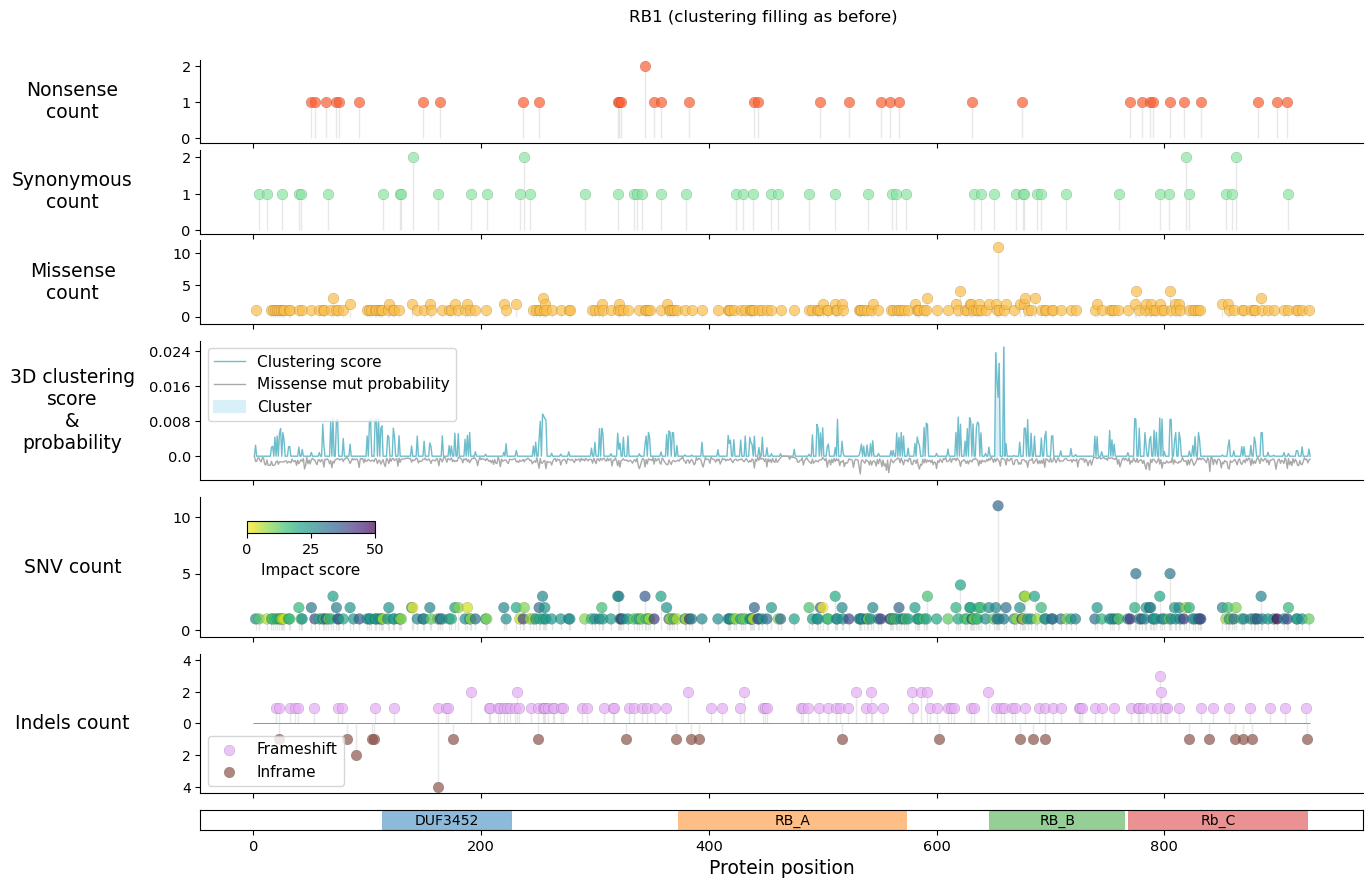

> RBM10 - ENST00000377604 - ENST00000377604 - A0A0S2Z4W4
Saving Fig3_plots/Fig3b/RBM10_alt_clust_filling.png


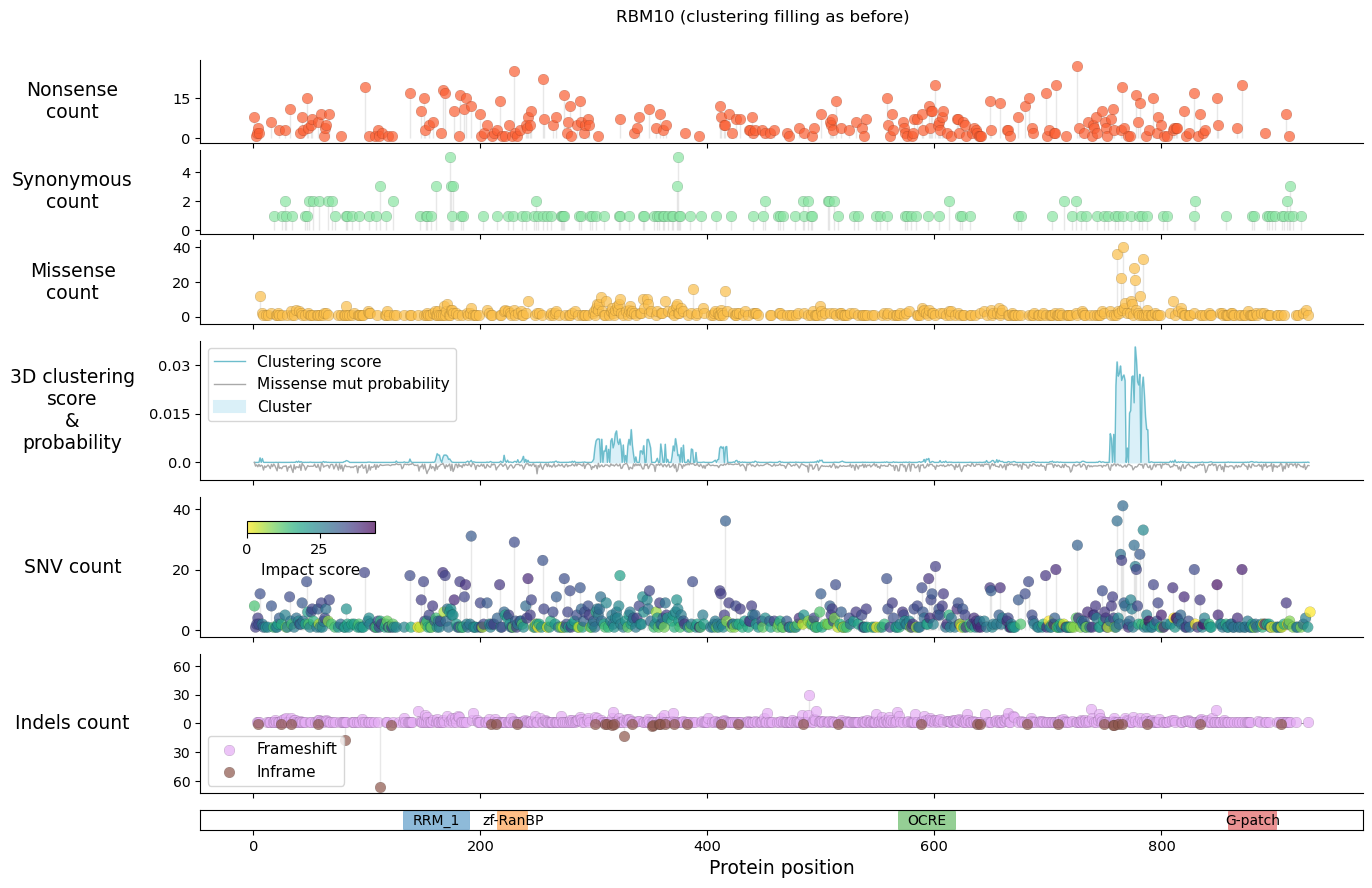

> TP53 - ENST00000269305 - ENST00000269305 - K7PPA8
Saving Fig3_plots/Fig3b/TP53_alt_clust_filling.png


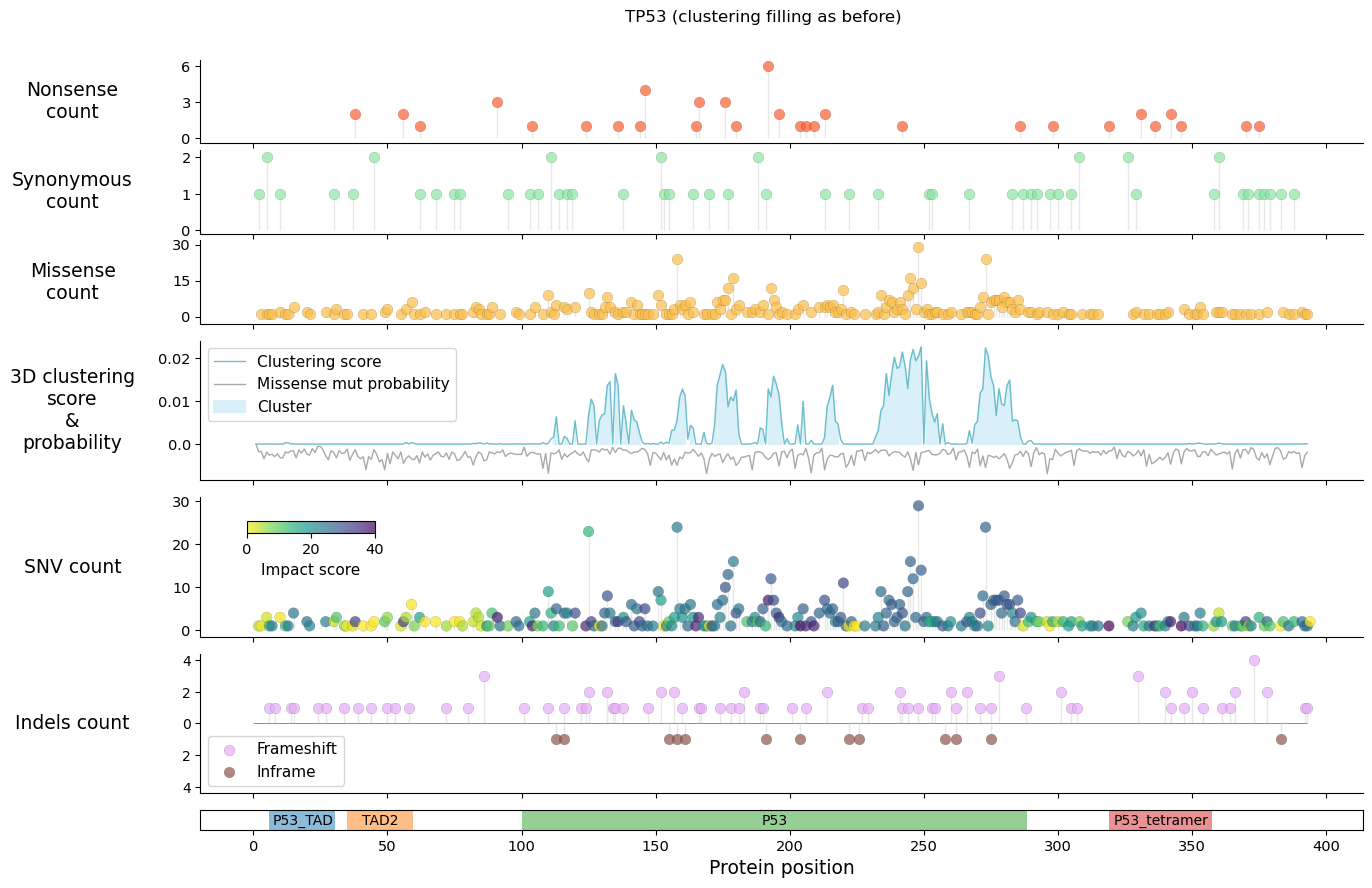

> FGFR3 - ENST00000440486 - ENST00000440486 - P22607
Saving Fig3_plots/Fig3b/FGFR3_alt_clust_filling.png


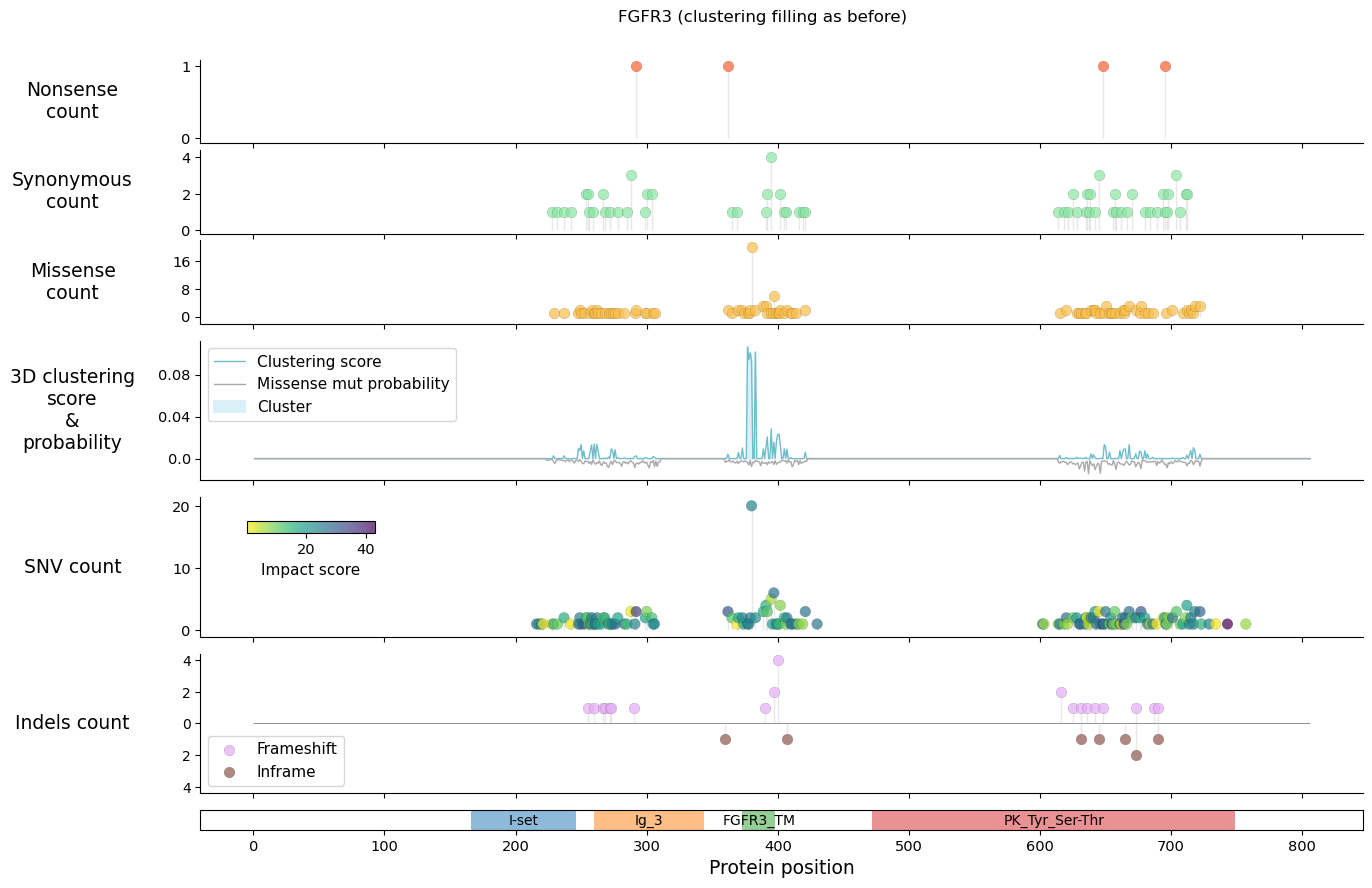

> CDKN1A - ENST00000244741 - ENST00000244741 - A0A024RCX5
Saving Fig3_plots/Fig3b/CDKN1A_alt_clust_filling.png


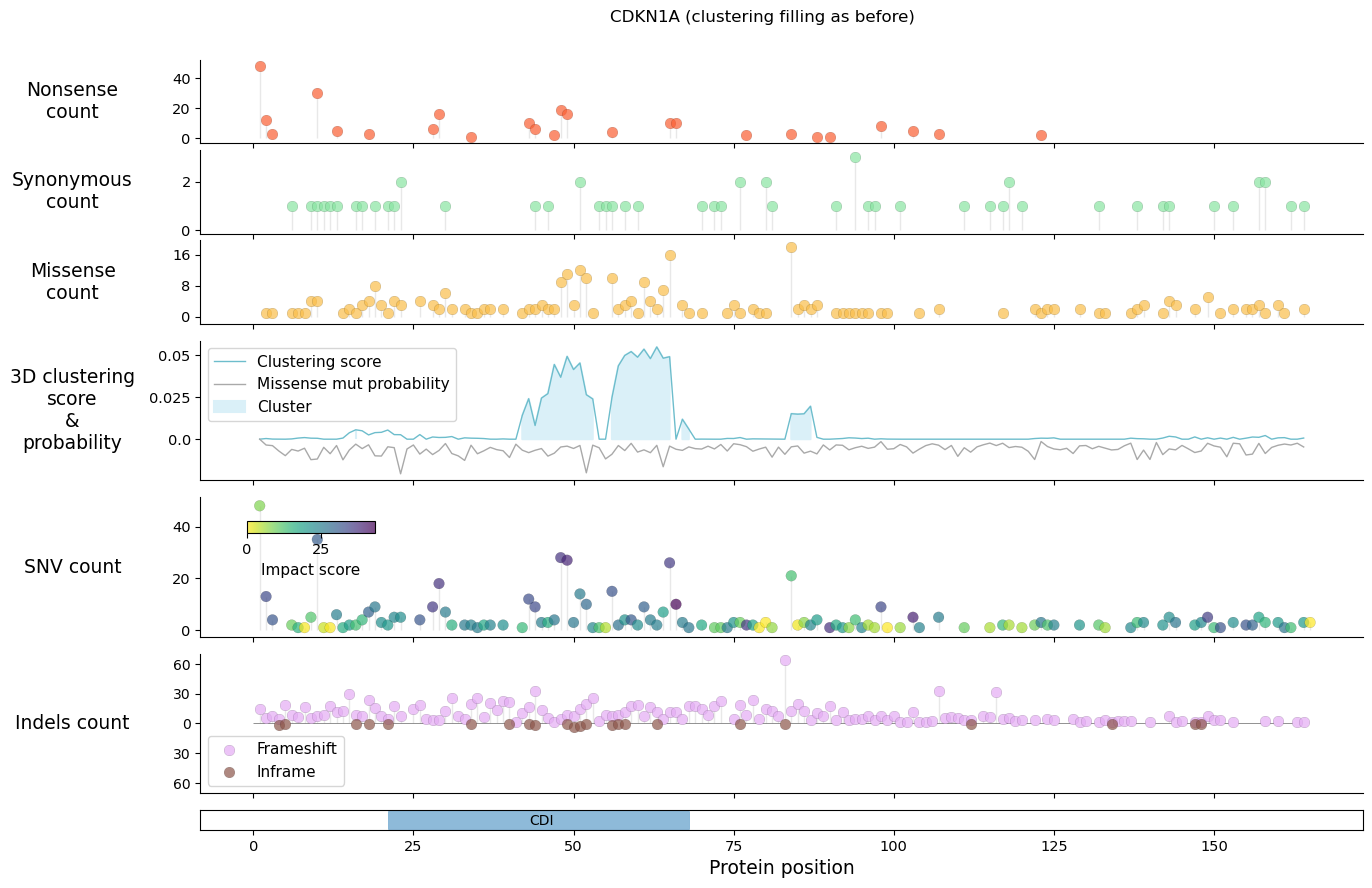

> FOXQ1 - ENST00000296839 - ENST00000296839 - Q9C009
Saving Fig3_plots/Fig3b/FOXQ1_alt_clust_filling.png


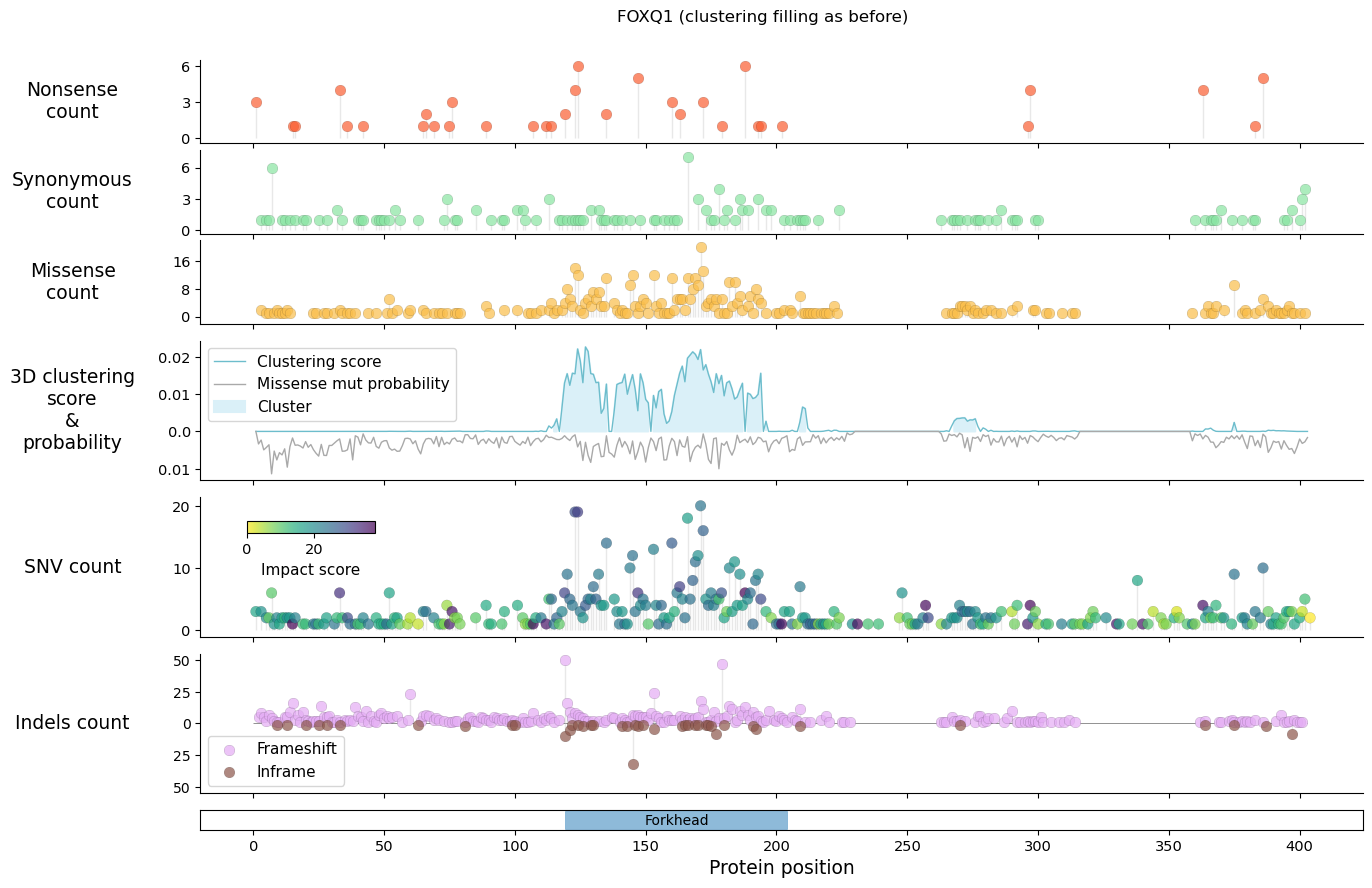

In [16]:
# Nonsense as nonsense canonical_Consequence_broader only
for gene in o3d_genes:

    plot_pars = init_plot_pars()        
    generate_plot(gene, 
                  o3d_seq_df,
                  o3d_annot_df,
                  o3d_prob,
                  o3d_score,
                  maf_df_f, 
                  snv_df, 
                  trunc_df, 
                  synon_df, 
                  miss_df,
                  plot_pars,
                  output_path="Fig3_plots/Fig3b",
                  clustering_full_filling=False)

In [ ]:
# Dont include extended clusters (as before)
for gene in o3d_genes:

    plot_pars = init_plot_pars()        
    generate_plot(gene, 
                  o3d_seq_df,
                  o3d_annot_df,
                  o3d_prob,
                  o3d_score,
                  maf_df_f, 
                  snv_df, 
                  trunc_df, 
                  synon_df, 
                  miss_df,
                  plot_pars,
                  output_path="Fig3_plots/Fig3b")